**Note**: If you run this notebook without a GPU (e.g. on *gesis-notebooks*) or want to skip the training of most methods, set **skipTraining** to *True*, as the notebook will otherwise take possibly weeks to run (instead of a few hours). The notebook still calculates the results correctly, merely the training of some (mostly GPU-intense) models will be skipped. It will instead use trained model files that I have created by running this exact notebook on my private GPU, which will be downloaded by this notebook automatically. It will also lead to using pre-computed SemScale results, as they take a long time to calculate.

In [1]:
skipTraining = True

**Note**: If you have a GPU, set **useGPU** to *True*, in order to speed up BERT.

In [2]:
useGPU = True

# Note: Left/Center/Right

**This notebook is a variation** on the notebook which compares far left and far right articles. Instead of just comparing two categories (left, right), we now add articles rated as center by AllSides. We want to see, how the methods will perform with this dataset which has a broader scope of articles.

# Positioning news articles from the NELA-GT-2018 dataset (Horne et al.)  on a left-right scale:

This python notebook analyzes news articles from the NELA-GT-2018 dataset (more specifically: news articles labeled by AllSides), published by Horne et al. and tries to classify them into left, center and right winged articles.

We put the methods we apply in this notebook into two categories: Those working on word frequencies and those working on word semantics.

The **word frequency** methods are:
- Wordfish
- Wordscores
- Linear Regression with token counts (baseline method)
- Feed-Forward neural network with token counts (baseline method)

The **word semantics** methods are:
- BERT
- SemScale
- Linear Regression with SemScale's embeddings (baseline method)
- Feed-forward neural network with SemScale's embeddings (baseline method)


The notebook starts out with R code (made accessible via the rpy2 library for python) and tries to position the articles first using methods from the political sciences: **Wordfish, Wordscores and SemScale**.

We then use **BERT** which uses it own kind of text preprocessing to position the documents.

Afterwards, as baseline methods we apply **linear regression** and **feed-forward neural networks** with similar inputs as to the methods we want to evaluate (i.e. **token counts** for the statistical methods and **SemScale's word embeddings** for the semantic methods).

This way, we create a diverse and comparable set of results in order to rank the methods at the end of this notebook.

The methods in this notebook are supposed to output a float value for each document between 0 and 1, with 0 being the most left position and 1 being the most right position. However, some methods also output values outside of that range. However, SemScale by default scales everything to 0,1 and Wordfish centers everything around the mean 0, thus containing a lot of negative values. Because of this, we only provide them in rescaled form. For all other methods, we provide both scaled and unscaled error metrics.

This notebook works on cross-fold validation. We split the training data in to **5 folds**, and we then calculate the **mean squared error (MSE)** for each of these folds. At the end of the notebook, we collect and present them.

In order to create a balanced dataset with as few confounders as possible, we first balance the number of outlets. We then remove articles which are outliers, and create synthetic articles, removing article length as a confounder. We then end up with the same number of articles from every outlet, with each article containing an equal number of words.

These articles all receive a **basic preprocessing** which removes most special characters, extra whitespace and layout syntax, in order to create natural looking text. For the word frequency methods, we apply **further preprocessing**, such as stemming, in order to reduce the word space, as would be appropriate for these methods.

Some methods output results outside of the 0-1 range or are very narrow in their output range (e.g. only outputting values from 0.4 to 0.6), which is why we calculate the metrics for both normalized and unnormalized results. In the metrics table and plots, a _(Norm.)_ signals normalized results. Some methods already output a 0-1 range scaled output, or are uninterpretable without 0-1 scaling (e.g. because of output which includes negative values). The metrics of these methods are provided only normalized, thus their name is followed by _(ONLY Norm.)_.


## Download Data

For this notebook, we need files which are too large for git. We will check if they are inside the project's folder, and if not, we download them.

The dataset which includes the news articles are saved inside an SQL file (articles.db).

We first check if the data exists on the user's computer, if not, we download it:

In [3]:
import urllib.request
import os
import gzip
import shutil

# Check if file already exists
if not os.path.isfile("articles.db"):
    # Download file
    print("Downloading file, please wait...")
    
    url = "https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/ULHLCB/HFWHB3"
    output_path = 'articles.db.gz'
    urllib.request.urlretrieve(url, output_path)

    # Unpack file
    print("Finished download!\nUnpacking....")
    with gzip.open('articles.db.gz', 'rb') as file_in:
        with open('articles.db', 'wb') as file_out:
            shutil.copyfileobj(file_in, file_out)
    os.remove("articles.db.gz") # Remove archive again
    print("Done!")


We check whether SemScale's embeddings file exists on the user's computer, if not, we download it:

In [4]:
import gdown # Library for downloading from Google Drive
import os
# Check if file already exists
if not os.path.isfile("embeddings_semscale.vec"):
    # Download file
    print("Downloading file, please wait...")
    
    url = "https://drive.google.com/uc?id=1Oy61TV0DpruUXOK9qO3IFsvL5DMvwGwD&export=download"
    output_path = 'embeddings_semscale.vec'
    gdown.download(url,output_path)
                      
    print("Done!")

We also unpack our trained models for in case we haven't yet:

In [5]:
models_folder = "models/models_horne_l_c_r"

In [6]:
# Check if we have the models, if we skip training
if skipTraining:
    if not os.path.isdir("models"):
        import zipfile

        print("Downloading file, please wait...")

        url = "https://cloud.uni-koblenz-landau.de/s/Mw4kECRq6RyFCbL/download"
        output_path = 'models.zip'
        urllib.request.urlretrieve(url, output_path)
        print("Done downloading, will extract now...")

        with zipfile.ZipFile("models.zip","r") as zip_file:
            zip_file.extractall()
            # We delete the zip form the disk to make space
            # os.system("rm models.zip")
            # We write the extracted zip to the disk again
            print("Done!")

Now that we downloaded everything, we create a variable to store the current time, so we can see how long the computation will take:

In [7]:
import datetime
start_time = datetime.datetime.now()

Since this is a python notebook, we need to use rpy2 to be able to run R code.
The next cell allows us to run rpy2 in notebook cells and later import R variables into the python environment of this notebook.

In [8]:
%load_ext rpy2.ipython
import rpy2.robjects as robjects

Cells including the line **%%R** contain R code.

Cells including the line **%%capture** do not print the output of that cell (for example because it is not of importance for the reader of the notebook).

We start our R session with imports of R libraries:

In [9]:
%%R
# Load R libraries
library(quanteda)
library(RSQLite)
library(caret)
library(mltools)
library(glue)
library(tm)

R[write to console]: Package version: 1.5.2

R[write to console]: Parallel computing: 2 of 8 threads used.

R[write to console]: See https://quanteda.io for tutorials and examples.

R[write to console]: 
Attaching package: ‘quanteda’


R[write to console]: The following object is masked from ‘package:utils’:

    View


R[write to console]: Loading required package: lattice

R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: NLP

R[write to console]: 
Attaching package: ‘NLP’


R[write to console]: The following object is masked from ‘package:ggplot2’:

    annotate


R[write to console]: 
Attaching package: ‘tm’


R[write to console]: The following objects are masked from ‘package:quanteda’:

    as.DocumentTermMatrix, stopwords




In [10]:
# We push the skipTraining variable into the R environment to access it later.
%Rpush skipTraining

The dataset which includes the news articles are saved inside an SQL file (articles.db) which we access and extract the articles into a dataframe variable *horne_df*:

In [11]:
%%R
# Establish SQL connection
con <- dbConnect(drv=SQLite(), dbname="articles.db")
# Create a dataframe containing all the articles
horne_df <- dbGetQuery(conn=con, statement=paste("SELECT * FROM articles", sep=""))
# Close SQL connection
dbDisconnect(con)

We also sort the names of the news outlets into the variables *left_outlets*, *center_outlets* and *right_outlets* from a .csv given by the authors of the dataset:

In [12]:
%%R
# Read .csv
outlets <- read.csv("outlets.csv")
# Get the outlets
left_outlets <- outlets[outlets$"Allsides..bias_rating"=="Left",1][drop=TRUE]
center_outlets <- outlets[outlets$"Allsides..bias_rating"=="Center",1][drop=TRUE]
right_outlets <- outlets[outlets$"Allsides..bias_rating"=="Right",1][drop=TRUE]
# Print number of outlets
print (glue("Number of left outlets: ", length(left_outlets)))
print (glue("Number of center outlets: ", length(center_outlets)))
print (glue("Number of right outlets: ", length(right_outlets)))

Number of left outlets: 17
Number of center outlets: 11
Number of right outlets: 14


As we can see, we have 17 left outlets, 11 center outlets and 14 right outlets. We will even out this imbalance in a few steps.

By looking into the data outside of this notebook, we noticed that the outlet "Raw Story" contains 3633 articles which contain the error message (*403 Forbidden*):

In [13]:
%%R
print(sum(grepl("403 Forbidden", horne_df[horne_df["source"] == "Raw Story", "content"])))

[1] 3633


We thus drop "Raw Story" from the left outlets:

In [14]:
%%R
left_outlets <- left_outlets[left_outlets != "Raw Story"]

Now we will check how many articles each outlet has by crating a matrix of articles per outlet together with their respective leaning:

In [15]:
%%R
# Define matrix shape
rows = length(c(left_outlets, center_outlets, right_outlets))
columns = 3
# Initialize matrix
articles_matrix <- matrix(ncol=columns, nrow=rows)
# Name columns
colnames(articles_matrix) <- c("#Articles", "Outlet","Leaning")
# Create leanings vector (one column in the matrix)
leanings = c(rep("left", length(left_outlets)), rep("center", length(center_outlets)), rep("right", length(right_outlets)))
# Construct matrix
i = 1
for(outlet in unlist(list(list(left_outlets), list(center_outlets) ,list(right_outlets)))){ # Some R versions need this syntax
    articles_matrix[i,] <- c(as.integer(sum(length(horne_df[horne_df["source"] == outlet, "content"]))), outlet, leanings[i])
    i = i + 1
}
# Print the matrix
print(articles_matrix[order(as.numeric(articles_matrix[,1])),])


      #Articles Outlet                      Leaning 
 [1,] "53"      "The Michelle Malkin Blog"  "right" 
 [2,] "265"     "New Yorker"                "left"  
 [3,] "310"     "Daily Signal"              "right" 
 [4,] "445"     "Business Insider"          "center"
 [5,] "514"     "Slate"                     "left"  
 [6,] "556"     "FiveThirtyEight"           "center"
 [7,] "892"     "FrontPage Magazine"        "right" 
 [8,] "994"     "Daily Kos"                 "left"  
 [9,] "1113"    "PBS"                       "center"
[10,] "1118"    "RightWingWatch"            "right" 
[11,] "1128"    "MotherJones"               "left"  
[12,] "1268"    "The Intercept"             "left"  
[13,] "1666"    "Yahoo News"                "left"  
[14,] "1702"    "Salon"                     "left"  
[15,] "1877"    "Breitbart"                 "right" 
[16,] "1968"    "The Hill"                  "center"
[17,] "2042"    "New York Daily News"       "left"  
[18,] "2316"    "Media Matters for America" "l

As we can see, the outlet "The Michelle Malkin Blog" from the right contains only 53 articles, thus we will drop it:

In [16]:
%%R
right_outlets <- right_outlets[right_outlets  != "The Michelle Malkin Blog"]

In [17]:
%%R
print (glue("Number of left outlets: ", length(left_outlets)))
print (glue("Number of center outlets: ", length(center_outlets)))
print (glue("Number of right outlets: ", length(right_outlets)))

Number of left outlets: 16
Number of center outlets: 11
Number of right outlets: 13


We still need to sort out 6 left outlets, 1 center outlet and 3 right outlets to balance out the number of outlets. We will remove those from both leanings with the least articles:

In [18]:
%%R
left_outlets <- left_outlets[left_outlets  != "New Yorker"]
left_outlets <- left_outlets[left_outlets  != "Slate"]
left_outlets <- left_outlets[left_outlets  != "Daily Kos"]
left_outlets <- left_outlets[left_outlets  != "MotherJones"]
left_outlets <- left_outlets[left_outlets  != "The Intercept"]
left_outlets <- left_outlets[left_outlets  != "Yahoo News"]

center_outlets <- center_outlets[center_outlets  != "Business Insider"]

right_outlets <- right_outlets[right_outlets  != "Daily Signal"]
right_outlets <- right_outlets[right_outlets  != "FrontPage Magazine"]
right_outlets <- right_outlets[right_outlets  != "RightWingWatch"]

We now have an equal number of outlets on both sides:

In [19]:
%%R
print (glue("Number of left outlets: ", length(left_outlets)))
print (glue("Number of center outlets: ", length(center_outlets)))
print (glue("Number of right outlets: ", length(right_outlets)))

Number of left outlets: 10
Number of center outlets: 10
Number of right outlets: 10


As already mentioned, we want to create synthetic articles with each article containing a fixed number of words. To see how many words we should pick as a parameter, we will look at the cumulative distribution of the article word counts in the dataset:

In [20]:
%%R
# Word count per article
left_word_count <- c()
center_word_count <- c()
right_word_count <- c()
count_index <- 1

for (outlet in left_outlets){

    articles_of_outlet <- horne_df[horne_df$source == outlet, "content"]

    print(glue("Handling left outlet {outlet}"))
    # Concatinate articles into one long string for easier separation
    for (article in articles_of_outlet) {
        left_word_count[count_index] <- length(unlist((strsplit(article, split = " "))))
        count_index <- count_index + 1
    }
}

for (outlet in center_outlets){

    articles_of_outlet <- horne_df[horne_df$source == outlet, "content"]

    print(glue("Handling center outlet {outlet}"))
    # Concatinate articles into one long string for easier separation
    for (article in articles_of_outlet) {
        center_word_count[count_index] <- length(unlist((strsplit(article, split = " "))))
        count_index <- count_index + 1
    }
}


for (outlet in right_outlets){

    articles_of_outlet <- horne_df[horne_df$source == outlet, "content"]

    print(glue("Handling right outlet {outlet}"))
    # Concatinate articles into one long string for easier separation
    for (article in articles_of_outlet) {
        right_word_count[count_index] <- length(unlist((strsplit(article, split = " "))))
        count_index <- count_index + 1
    }
}


Handling left outlet Alternet
Handling left outlet Daily Beast
Handling left outlet MSNBC
Handling left outlet Media Matters for America
Handling left outlet New York Daily News
Handling left outlet Politicus USA
Handling left outlet Salon
Handling left outlet The Huffington Post
Handling left outlet ThinkProgress
Handling left outlet Vox
Handling center outlet Al Jazeera
Handling center outlet BBC
Handling center outlet CNBC
Handling center outlet FiveThirtyEight
Handling center outlet NPR
Handling center outlet PBS
Handling center outlet Real Clear Politics
Handling center outlet Reuters
Handling center outlet The Hill
Handling center outlet USA Today
Handling right outlet Breitbart
Handling right outlet CNS News
Handling right outlet Daily Mail
Handling right outlet Infowars
Handling right outlet National Review
Handling right outlet New York Post
Handling right outlet RedState
Handling right outlet The Daily Caller
Handling right outlet The Gateway Pundit
Handling right outlet West

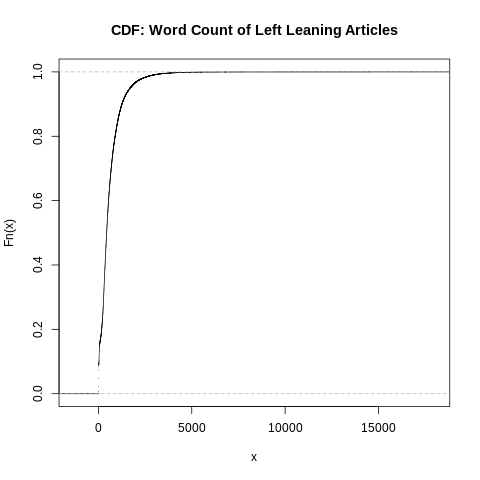

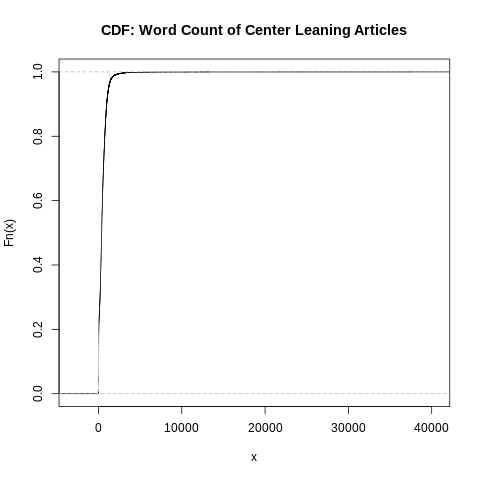

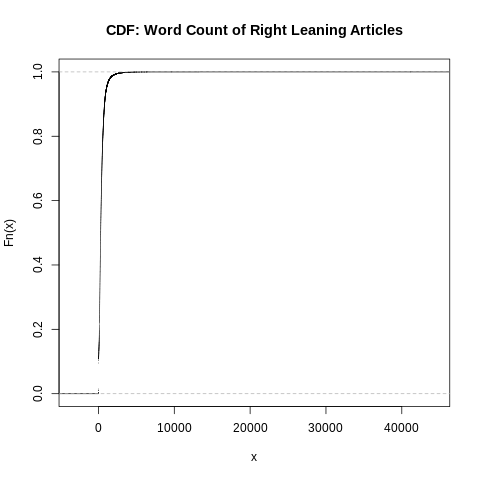

In [21]:
%%R
plot(ecdf(left_word_count), main="CDF: Word Count of Left Leaning Articles")
plot(ecdf(center_word_count), main="CDF: Word Count of Center Leaning Articles")
plot(ecdf(right_word_count),main="CDF: Word Count of Right Leaning Articles")

As we can see, we have quite extreme outliers in our dataset. We want to remove all articles with less than 50 and more than 5000 words, as those may be faulty data in the dataset. In any case, they would not be what we would recognize as an article.

In [22]:
%%R
# Indices for loops
left_word_count_index <- 1
center_word_count_index <- 1
right_word_count_index <- 1

left_outlet_index <- 1
center_outlet_index <- 1
right_outlet_index <- 1

# List of articles without outliers
left_articles <- list()
center_articles <- list()
right_articles <- list()

# Vectors containing word lengths
left_word_count <- c()
center_word_count <- c()
right_word_count <- c()

# Iterate over each outlet
for (outlet in left_outlets){
    is_first_run <- TRUE 
    articles_of_outlet <- horne_df[horne_df$source == outlet, "content"]
    print(glue("Handling left outlet {outlet}"))
    # Iterate over each article per outlet
    for (article in articles_of_outlet) {
        word_count <- length(unlist((strsplit(article, split = " "))))
        # Check if the word count hints at an outlier
        if (word_count > 50 && word_count < 5000) {
            # If we run the loop for the first time, the index is out of bounds
            if (is_first_run)  {
                left_articles[[left_outlet_index]] <- article
                is_first_run <- FALSE
            }
            else {
                left_articles[[left_outlet_index]] <- c(left_articles[[left_outlet_index]], article)
            }
            left_word_count[left_word_count_index] <- word_count
            left_word_count_index <- left_word_count_index + 1
        }
    }
    left_outlet_index <- left_outlet_index + 1
}

# Iterate over each outlet
for (outlet in center_outlets){
    is_first_run <- TRUE
    articles_of_outlet <- horne_df[horne_df$source == outlet, "content"]
    print(glue("Handling center outlet {outlet}"))
    # Iterate over each article per outlet
    for (article in articles_of_outlet) {
        word_count <- length(unlist((strsplit(article, split = " "))))
        # Check if the word count hints at an outlier
        if (word_count > 50 && word_count < 5000) {
            # If we run the loop for the first time, the index is out of bounds
            if (is_first_run)  {
                center_articles[[center_outlet_index]] <- article
                is_first_run <- FALSE
            }
            else {
                center_articles[[center_outlet_index]] <- c(center_articles[[center_outlet_index]], article)
            }
            center_word_count[center_word_count_index] <- word_count
            center_word_count_index <- center_word_count_index + 1
        }
    }
    center_outlet_index <- center_outlet_index + 1
}

# Iterate over each outlet
for (outlet in right_outlets){
    is_first_run <- TRUE
    articles_of_outlet <- horne_df[horne_df$source == outlet, "content"]
    print(glue("Handling right outlet {outlet}"))
    # Iterate over each article per outlet
    for (article in articles_of_outlet) {
        word_count <- length(unlist((strsplit(article, split = " "))))
        # Check if the word count hints at an outlier
        if (word_count > 50 && word_count < 5000) {
            # If we run the loop for the first time, the index is out of bounds
            if (is_first_run)  {
                right_articles[[right_outlet_index]] <- article
                is_first_run <- FALSE
            }
            else {
                right_articles[[right_outlet_index]] <- c(right_articles[[right_outlet_index]], article)
            }
            right_word_count[right_word_count_index] <- word_count
            right_word_count_index <- right_word_count_index + 1
        }
    }
    right_outlet_index <- right_outlet_index + 1
}

Handling left outlet Alternet
Handling left outlet Daily Beast
Handling left outlet MSNBC
Handling left outlet Media Matters for America
Handling left outlet New York Daily News
Handling left outlet Politicus USA
Handling left outlet Salon
Handling left outlet The Huffington Post
Handling left outlet ThinkProgress
Handling left outlet Vox
Handling center outlet Al Jazeera
Handling center outlet BBC
Handling center outlet CNBC
Handling center outlet FiveThirtyEight
Handling center outlet NPR
Handling center outlet PBS
Handling center outlet Real Clear Politics
Handling center outlet Reuters
Handling center outlet The Hill
Handling center outlet USA Today
Handling right outlet Breitbart
Handling right outlet CNS News
Handling right outlet Daily Mail
Handling right outlet Infowars
Handling right outlet National Review
Handling right outlet New York Post
Handling right outlet RedState
Handling right outlet The Daily Caller
Handling right outlet The Gateway Pundit
Handling right outlet West

Now let us look at the cumulative distribution again:

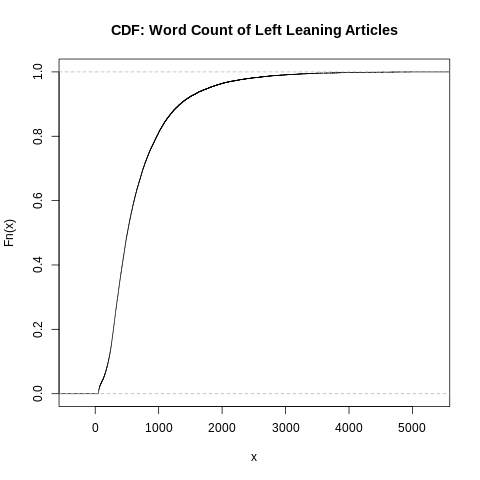

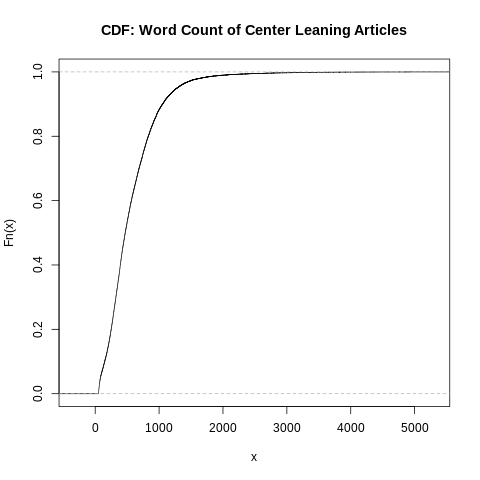

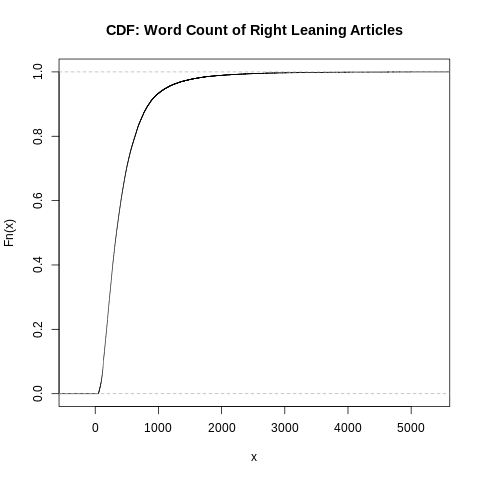

In [23]:
%%R
plot(ecdf(left_word_count), main="CDF: Word Count of Left Leaning Articles")
plot(ecdf(center_word_count), main="CDF: Word Count of Center Leaning Articles")
plot(ecdf(right_word_count), main="CDF: Word Count of Right Leaning Articles")

Using the elbow method, we decide for an article length of 1000 words.

From the remaining articles, we now form 35 articles from each outlet, with each article containing 1000 words:

In [24]:
%%R
# Create number of articles from each outlet with a fixed amount of words in articles
create_samples <- function(num_of_articles, words_in_article) {
    # Prepare article variables
    left_news <- c()
    center_news <- c()
    right_news <- c()
    
    print("Processing left news...")
    
    for (articles_of_outlet in left_articles){
    # Concatinate articles into one long string for easier separation
    appended_articles <- paste(articles_of_outlet, collapse = ' ')
    all_words <- unlist((strsplit(appended_articles, split = " ")))
    start_index <- 1
    end_index <- words_in_article
    # Create num_of_articles times synthetic articles out of all_wordss
    for (i in 1:num_of_articles){
        # Get extracted words
        extracted_words =  all_words[start_index:end_index]
        # Create an article out of them
        extracted_words <- paste(extracted_words, collapse=" ")
        # Append to already collected articles
        left_news <- c(left_news, extracted_words)
        # Increase indices
        start_index <- end_index + 1
        end_index <- start_index + words_in_article
    }
    }
    
    print("Processing center news...")
    
    for (articles_of_outlet in center_articles){
    # Concatinate articles into one long string for easier separation
    appended_articles <- paste(articles_of_outlet, collapse = ' ')
    all_words <- unlist((strsplit(appended_articles, split = " ")))
    start_index <- 1
    end_index <- words_in_article
    # Create num_of_articles times synthetic articles out of all_words
    for (i in 1:num_of_articles){
        # Get extracted words
        extracted_words =  all_words[start_index:end_index]
        # Create an article out of them
        extracted_words <- paste(extracted_words, collapse=" ")
        # Append to already collected articles
        center_news <- c(center_news, extracted_words)
        # Increase indices
        start_index <- end_index + 1
        end_index <- start_index + words_in_article
    }
    }
    

    print("Processing right news...")
    
    for (articles_of_outlet in right_articles){
    # Concatinate articles into one long string for easier separation
    appended_articles <- paste(articles_of_outlet, collapse = ' ')
    all_words <- unlist((strsplit(appended_articles, split = " ")))
    start_index <- 1
    end_index <- words_in_article
    # Iterate over appended articles and create articles of word
    for (i in 1:num_of_articles){
        # Get extracted words
        extracted_words =  all_words[start_index:end_index]
        # Create an article out of them
        extracted_words <- paste(extracted_words, collapse=" ")
        # Append to already collected articles
        right_news <- c(right_news, extracted_words)
        # Incease indices
        start_index <- end_index + 1
        end_index <- start_index + words_in_article
    }
    }
    
    return (list(left_news, center_news, right_news))
    print("DONE!")
}
new_sampled_news <- create_samples(num_of_articles=35,words_in_article=1000)

# Split sampled news into left, center and right news
left_news <- new_sampled_news[[1]]
center_news <- new_sampled_news[[2]]
right_news <- new_sampled_news[[3]]

# Remove temporary news variable and call garbage collection to free memory
remove(new_sampled_news)
remove(horne_df)
remove(left_articles)
remove(center_articles)
remove(right_articles)
gc()

[1] "Processing left news..."
[1] "Processing center news..."
[1] "Processing right news..."
          used  (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells 2380745 127.2    5873197  313.7   5873197  313.7
Vcells 8892857  67.9  320101641 2442.2 400125076 3052.8


Let us look at an example article we just created:

In [25]:
%%R
center_news[1]

[1] "Afghan security forces have battled two gunmen who stormed a government building in the eastern Afghan city of Jalalabad, taking dozens of people hostage.\r\n\r\nThe siege on Tuesday at the refugees and repatriations directorate compound, which began after a suicide bomber detonated explosives at the building's entrance, lasted for several hours, during which intermittent gunfire and blasts could be heard.\r\n\r\nSpokesman Attaullah Khogyani, spokesman for the government of Nangarhar province, said the incident appeared to be over with two gunmen killed and much of the building destroyed.\r\n\r\nHe said at least 15 people had been killed and 15 wounded although the total may rise as rescue workers search the site. Sohrab Qaderi, a member of the local provincial council, said eight had been killed and as many as 30 wounded.\r\n\r\nThere was no immediate claim of responsibility.\r\n\r\n\"Around 11am local time, a car laden with explosives, drove up to this compound, two gunmen jumpe

As we can see, the article is now a concatenation of articles until we reach 1000 words. However, sticking to the words are unwanted things like the escape sequences (e.g. "\n"), which we will remove in the course of the next cells:

## Preprocessing

The word frequency methods we look at benefit from preprocessing steps such as removing stopwords, non-numeric characters and stemming words. Since we will use SemScale and the embeddings from SemScale later in our baseline methods, we want to see if SemScale's embeddings includes stop words and punctuation. Thus we print the first vectors inside SemScale's embedding matrix:

In [26]:
loop_counter = 0 # We want to see the first 30 vectors

with open('embeddings_semscale.vec') as f:
    for line in f:
        word, *vector = line.split()
        # Check if any word is a digit
        if(any(i.isdigit() for i in word)):
            print("Contains digit:", word)
        # Check if any word contains upper-case letters
        if(any(i.isupper() for i in word)):
            print("Contains upper-case letter:", word)
        # Print the words
        print(word)
        # Increase loop counter
        loop_counter += 1
        if (loop_counter >= 30):
            break

en__,
en__.
en__the
en__</s>
en__of
en__-
en__in
en__and
en__'
en__)
en__(
en__to
en__a
en__is
en__was
en__on
en__s
en__for
en__as
en__by
en__that
en__it
en__with
en__from
en__at
en__he
en__this
en__be
en__i
en__an


As we can see, punctuations and stop words are part of the embedding. Also, the embeddings do not contain digits or upper-case words (as the print commands in the if's do not get executed). In addition to that, the authors of SemScale also use unaltered input.

Since we want to start with the most natural text, we will remove extra whitespace, special symbols, numbers and layout syntax for all methods.

Afterwards, we will create a further processed dataset specifically for our word frequency methods, where we try to reduce the complexity and size of the vector space. For now, we will remove everything except the symbols ' ? ! . : , and small and capital letters in order to create our base data for all methods:

In [27]:
%%R
left_news <- gsub("[^ '?!.:,a-zA-Z]", " ",left_news)
center_news <- gsub("[^ '?!.:,a-zA-Z]", " ",center_news)
right_news <- gsub("[^ '?!.:,a-zA-Z]", " ",right_news)
# The method above create a lot of extra whitespace when replacing the removed symbols with it.
# We thus remove extra whitespace now:
left_news <- gsub("\\s+"," ",left_news)
center_news <- gsub("\\s+"," ",center_news)
right_news <- gsub("\\s+"," ",right_news)

As we can see, the text looks a lot more natural now:

In [28]:
%%R
center_news[1]

[1] "Afghan security forces have battled two gunmen who stormed a government building in the eastern Afghan city of Jalalabad, taking dozens of people hostage. The siege on Tuesday at the refugees and repatriations directorate compound, which began after a suicide bomber detonated explosives at the building's entrance, lasted for several hours, during which intermittent gunfire and blasts could be heard. Spokesman Attaullah Khogyani, spokesman for the government of Nangarhar province, said the incident appeared to be over with two gunmen killed and much of the building destroyed. He said at least people had been killed and wounded although the total may rise as rescue workers search the site. Sohrab Qaderi, a member of the local provincial council, said eight had been killed and as many as wounded. There was no immediate claim of responsibility. Around am local time, a car laden with explosives, drove up to this compound, two gunmen jumped out and then they set off the first of several

Since this was very basic preprocessing for the **semantic methods** just to make the data at least similar to an actual news article, we will still refer to this data created as **unprocessed data** later, as it is very different from the data we will create now:

For our **word frequency methods** we want to apply **further text preprocessing**, which is:

- **Lowercasing**: Set all upper case letters to lower case. This helps us reduce the count of words.


- **Removal of punctuation and numbers**:  Punctuation and numbers are not of benefit for our word frequency methods, as they give little semantic information when their count per document appears in a document-feature matrix or a token count vector.


- **Removal of stopwords**: Stopwords such as "the" or "is" and others are not words containing a direct sentiment on their own and are thus removed.


- **Stemming**: Words in the texts are pruned to their base form, e.g. "runner" and "running" may be pruned to "run". This is already an example of what problems stemming may cause (e.g. turning verbs into nouns), however, it greatly reduces the number of words inside a text corpus and is thus beneficial for our word frequency methods.


- **Removal of extra whitespace**: Through previous preprocessing and through faults in the dataset, extra whitespace in the text may exist which is removed.

We now apply the preprocessing steps mentioned above:

In [29]:
%%R

preprocess_documents <- function(unprocessed_docs){

  # Create corpus for cleanup methods
  corpus <- (VectorSource(unprocessed_docs))
  corpus <- Corpus(corpus)
  
  # Clean up corpus
  corpus_clean <- tm_map(corpus, content_transformer(tolower))
  corpus_clean <- tm_map(corpus_clean, removePunctuation)
  corpus_clean <- tm_map(corpus_clean, removeNumbers)
  corpus_clean <- tm_map(corpus_clean, removeWords, stopwords('english'))
  corpus_clean <- tm_map(corpus_clean, stemDocument, language = "english")
  corpus_clean <- tm_map(corpus_clean, stripWhitespace)
  
  # Revert to string
  processed_docs <- sapply(corpus_clean$content, as.character)
  return (unname(processed_docs)) # Needs to be an unnamed list
}

# Sort processed articles into leanings.
left_news_processed <- preprocess_documents(left_news)
center_news_processed <- preprocess_documents(center_news)
right_news_processed <- preprocess_documents(right_news)

We shuffle the data and create folds:

In [30]:
%%R
num_folds <- 5 # Number of folds

# First we append the data both unprocessed  (for semantic methods)
# and processed (for  frequency methods)
news_appended <- c(left_news, center_news, right_news)
news_appended_processed <- c(left_news_processed, center_news_processed, right_news_processed)

# Append the labels
labels <- c(rep(0, length(left_news)), rep(0.5, length(center_news)) ,rep(1, length(right_news)))

# Shuffle datasets, setting same seeds assures equal shuffeling

# The way R works, a seed has to be set again before every randomized action
set.seed(42)
news_appended <- sample(news_appended,(length(news_appended)))

set.seed(42)
news_appended_processed <- sample(news_appended_processed,(length(news_appended_processed)))

# The labels remain the same
set.seed(42) 
labels <- sample(labels, length(labels))

# We only create one set of fold indices for both, 
# as both datasets have the same length
# and if we we were to create new folds, they would be mixed up differently
# when using this method and thus not comparable, even with the same seed...
set.seed(42)
folds <- createFolds(news_appended, k = num_folds, list = TRUE)


# Prepare lists for unprocessed and processed data
X_train <- list()
X_test <- list()
X_train_processed <- list()
X_test_processed <- list()

# The y variables remain the same for both
y_train <- list()
y_test <- list()


for (i in 1:num_folds) {
    
  # We create the datasets using the folds as indices
  X_train[[i]] <- news_appended[unlist(folds[-i])]
  X_train_processed[[i]] <- news_appended_processed[unlist(folds[-i])]
    
  X_test[[i]] <- news_appended[unlist(folds[i])]
  X_test_processed[[i]] <- news_appended_processed[unlist(folds[i])]
  
  y_train[[i]] <- labels[unlist(folds[-i])]
  y_test[[i]] <- labels[unlist(folds[i])]
    
}

In [31]:
%%R
# We check if any fold by chance does not contain all labels
for (i in 1:num_folds) {
    if (!(0 %in% y_train[[i]] && 0.5 %in% y_train[[i]] && 1 %in% y_train[[i]] &&
         0 %in% y_test[[i]] &&  0.5 %in% y_test[[i]]  && 1 %in% y_test[[i]])){
        print(glue("ATTENTION! Missing value in fold {i}, quitting..."))
        quit()
    }
}

Example of how the processed data differs from the "unprocessed" data:

In [32]:
%%R
print(substring(X_train[[1]][1], 1,100))
print(substring(X_train_processed[[1]][1], 1,100))

[1] "to say whether he would support any specific gun control measures, saying, Thats an issue were going"
[1] "say whether support specif gun control measur say that issu go look work develop legisl trump strong"


We now create the document-feature matrices (DFMs are the Quanteda equivalent for *document-term matrices*) named *dfm_X_train* and *dfm_X_test*  as train and test data).

We will use these matrices for Wordfish and Wordscores.

In [33]:
%%R

dfm_X_train <- list()
dfm_X_test <- list()

# Create DFMs for every fold
for (i in 1:num_folds) {
  dfm_X_train[[i]] <- dfm(X_train_processed[[i]])
  dfm_X_test[[i]] <- dfm(X_test_processed[[i]])
}

As already stated, we split the training data into 5 folds, and then we calculate the *mean-squared-error* and *pearson* and *spearman correlation* for each of these folds. At the end of the notebook, we collect and present the mean and standard deviations over the folds for every method. 

For this, we initialize a dataframe:

In [34]:
import pandas as pd
import numpy as np
MSEs_df = pd.DataFrame(columns=["method","mean", "std"])
cor_p_df = pd.DataFrame(columns=["method","mean", "std"])
cor_s_df = pd.DataFrame(columns=["method","mean", "std"])

# Methods

## Wordscores (frequency method)

We apply Wordscores to our just created document-feature matrix in *dfm_X_train* and save the output in *ws_results*:

In [35]:
%%R
ws <- list() # List of wordscore models
ws_results <- list() # List of wordscore results 

# Iterate over each fold
for (i in 1:num_folds) {
  print(glue("Handling fold {i} out of {num_folds}"))
  set.seed(42)
  ws[[i]] <- textmodel_wordscores(dfm_X_train[[i]], y=y_train[[i]])
  set.seed(42)
  ws_results[[i]] <- predict(ws[[i]], newdata = dfm_X_test[[i]])
}


Handling fold 1 out of 5
Handling fold 2 out of 5
Handling fold 3 out of 5
Handling fold 4 out of 5
Handling fold 5 out of 5


**Wordscores Results Plot** - The left side of the x-axis shows left-leaning articles with their respective score given by Wordscores in the y-axis. Ideally, all values would have a value close to 0 for the left-sided articles, and a value close to 1 for right-sided articles.

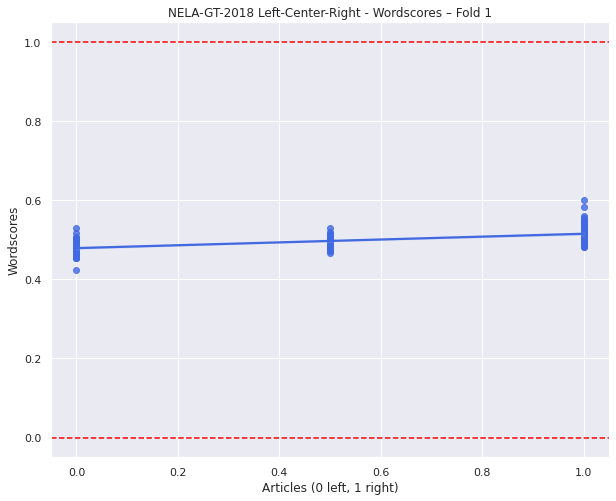

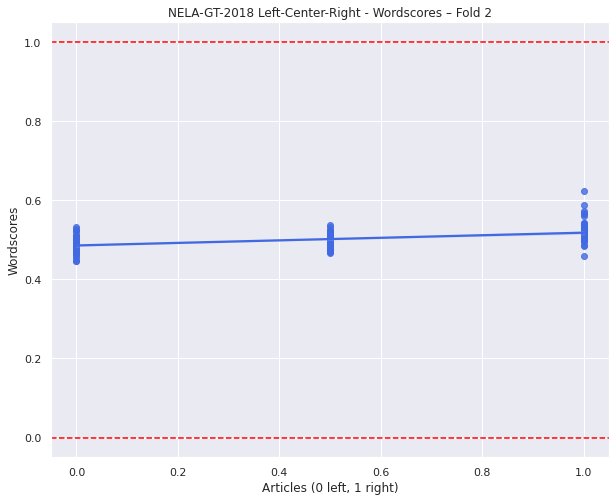

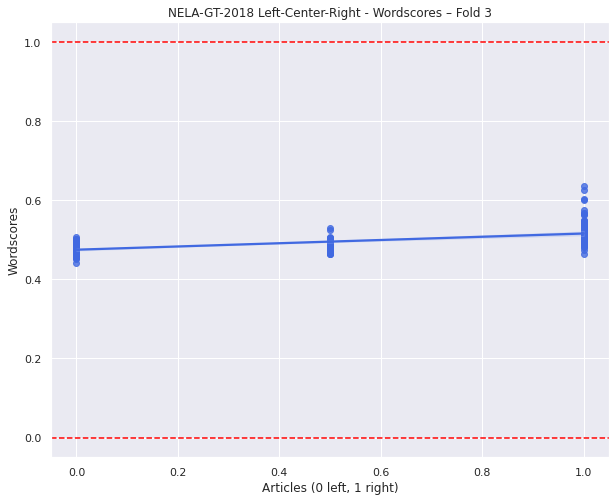

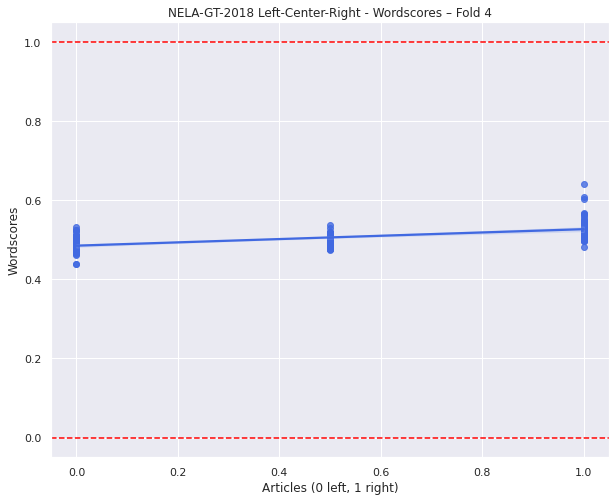

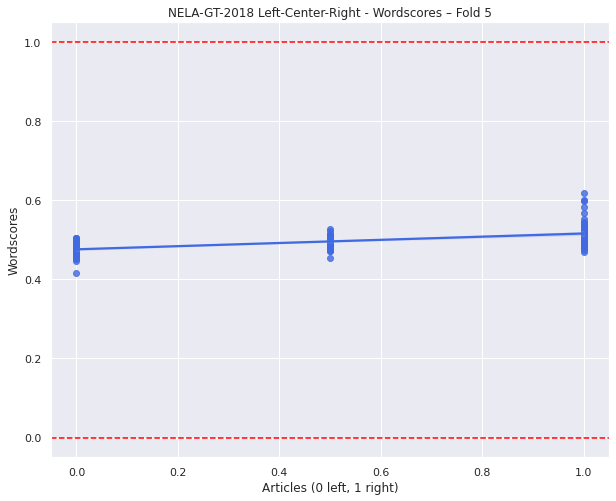

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import logging
import warnings
warnings.filterwarnings("ignore") 
import logging
logger = logging.getLogger().setLevel(logging.ERROR)
# Get number of folds
# For the int() to work, we first need to convert it to a numpy array
num_folds = int(robjects.r('num_folds')[0])

method_name = "Wordscores"
notebook_name = "NELA-GT-2018 Left-Center-Right"
fig_dir = "figs/" + notebook_name  + "/" + method_name + "/"


X = np.array(robjects.r['y_test'])
y = np.array(robjects.r['ws_results'])
for i in range(num_folds): 
    X[i] = np.array(X[i], dtype = np.float64)
    y[i] = np.array(y[i], dtype = np.float64)

if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)
for i in range(num_folds):
    sns.set(rc={'figure.figsize':(10,8)})
    fig = sns.regplot(x=X[i], y=y[i], color="royalblue")
    fig.set_xlim(-0.05,1.05) # So points aren't cut off on the sides
    plt.axhline(1, ls='--', color="red")
    plt.axhline(0, ls='--', color="red")
    fig.set_xlabel("Articles (0 left, 1 right)")
    fig.set_ylabel(method_name)
    fig.set_title(notebook_name + " - " + method_name + " – Fold " + str(i + 1))
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".svg")
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".pdf")
    plt.show()

We extract the metrics for later analysis:

In [37]:
%%R
MSEs_ws <- mapply(mse, ws_results, y_test)

# Define normalization function
normalize <- function(x){(x-min(x))/(max(x)-min(x))}
ws_results_norm <- list()
for (i in 1:num_folds) {
    ws_results_norm[[i]] <- normalize(ws_results[[i]])
}

MSEs_ws_norm <- mapply(mse, ws_results_norm, y_test)

We also extract Pearson and Spearman correlation:

In [38]:
%%R
cor_p_ws <- mapply(cor, ws_results, y_test, method="pearson")
cor_s_ws <- mapply(cor, ws_results, y_test, method="spearman")

cor_p_ws_norm <- mapply(cor, ws_results_norm, y_test, method="pearson")
cor_s_ws_norm <- mapply(cor, ws_results_norm, y_test, method="spearman")

In [39]:
MSEs_ws = np.array(robjects.r['MSEs_ws'])
MSEs_df = MSEs_df.append(
            {"method": "Wordscores",
             "mean":np.mean(MSEs_ws),
             "std":np.std(MSEs_ws)},
            ignore_index=True)

cor_p_ws = np.array(robjects.r['cor_p_ws'])

cor_p_df = cor_p_df.append(
            {"method": "Wordscores",
             "mean":np.mean(cor_p_ws),
             "std":np.std(cor_p_ws)},
            ignore_index=True)

cor_s_ws = np.array(robjects.r['cor_s_ws'])

cor_s_df = cor_s_df.append(
            {"method": "Wordscores",
             "mean":np.mean(cor_s_ws),
             "std":np.std(cor_s_ws)},
            ignore_index=True)


MSEs_ws_norm = np.array(robjects.r['MSEs_ws_norm'])
MSEs_df = MSEs_df.append(
            {"method": "Wordscores (Norm.)",
             "mean":np.mean(MSEs_ws_norm),
             "std":np.std(MSEs_ws_norm)},
            ignore_index=True)

cor_p_ws_norm = np.array(robjects.r['cor_p_ws_norm'])

cor_p_df = cor_p_df.append(
            {"method": "Wordscores (Norm.)",
             "mean":np.mean(cor_p_ws_norm),
             "std":np.std(cor_p_ws_norm)},
            ignore_index=True)

cor_s_ws_norm = np.array(robjects.r['cor_s_ws_norm'])

cor_s_df = cor_s_df.append(
            {"method": "Wordscores (Norm.)",
             "mean":np.mean(cor_s_ws_norm),
             "std":np.std(cor_s_ws_norm)},
            ignore_index=True)

## Wordfish (frequency method)
Wordfish requires two labeled documents with opposite political positions as reference documents and from that Wordfish positions the other documents in relation to these two reference documents, as the reference documents get assigned both ends of the output scale. No further training is required. In order to simulate the typical train/test-data environment, we take two labeled documents from the training-data and append them to the test-data. On this, we will then run Wordfish.

First we need to find opposite documents:

In [40]:
%%R
for (i in 1:num_folds) {
  print(y_train[[i]][7:8])
}

[1] 1 0
[1] 1 0
[1] 1 0
[1] 1 0
[1] 1 0


We can see that documents at positions 7 and 8 for every split from the training dataset are opposite ideologies (0 and 1).

We save the reference documents in the variable *wf_train_docs*:

In [41]:
%%R
wf_train_docs <- list()
for (i in 1:num_folds) {
    # We select the documents from the training data by boolean values as indices
    wf_train_docs[[i]] = dfm_subset(dfm_X_train[[i]], c(rep(FALSE,6), TRUE , TRUE, rep(FALSE, length(X_train_processed[[i]])-8)))
}

We check if the variable indeed contains the training texts:

In [42]:
%%R
print(wf_train_docs[[i]][1:2,1])

Document-feature matrix of: 2 documents, 1 feature (50.0% sparse).
2 x 1 sparse Matrix of class "dfm"
       features
docs    fiscal
  text7      0
  text8      2


As we can see, the two texts form above are indeed inside the *wf_train_docs* document-feature matrix.

Because Wordfish crashes when applied to document collections which are very sparse, we do need to trim the corpus to terms which appear in at least 2 documents. We assume this reduces the quality of the results, as Wordfish is also scoring relatively badly. This is why we will not apply the same term removal to the other methods, as it is an implementation fault of Wordfish! I have talked with Federico Nanni, the author of SemScale, who reported the same problem!

This cell can take some time to run!

We append these two documents to the test-data, creating the variable *data_wf* and remove terms which appear in less than 2 documents. We then calculate the Wordfish results and save them in *wf_results*:

In [43]:
%%R
data_wf <- list()
wf_results <- list() 
for (i in 1:num_folds) {
    print(glue("Handling fold {i} out of {num_folds}"))
    data_wf[[i]] <- rbind(wf_train_docs[[i]], dfm_X_test[[i]]) # Add the two training docs at the top
    data_wf[[i]] <- dfm_trim(data_wf[[i]], min_docfreq = 2) # Only leave in documents that appear twice
    set.seed(42)
    wf_results[[i]] <- textmodel_wordfish(data_wf[[i]], dir=c(1,2) , sparse = TRUE)$theta
}

Handling fold 1 out of 5
Handling fold 2 out of 5
Handling fold 3 out of 5
Handling fold 4 out of 5
Handling fold 5 out of 5


We drop the two reference documents which were put at the beginning of *wf_results* from every fold:

In [44]:
%%R
for (i in 1:num_folds) {
wf_results[[i]] <- wf_results[[i]][- c(1,2)]
}

We min-max normalize the Wordfish results to make them comparable to our other methods:

In [45]:
%%R
# Define normalization function
normalize <- function(x){(x-min(x))/(max(x)-min(x))}

wf_results_normalized <- list()
for (i in 1:num_folds) {
wf_results_normalized[[i]] <- normalize(wf_results[[i]])
}

We plot the normalized Wordfish results (just as we did with Wordscores):

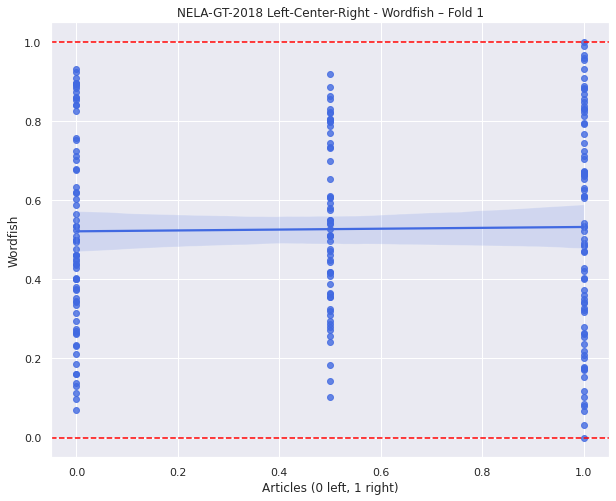

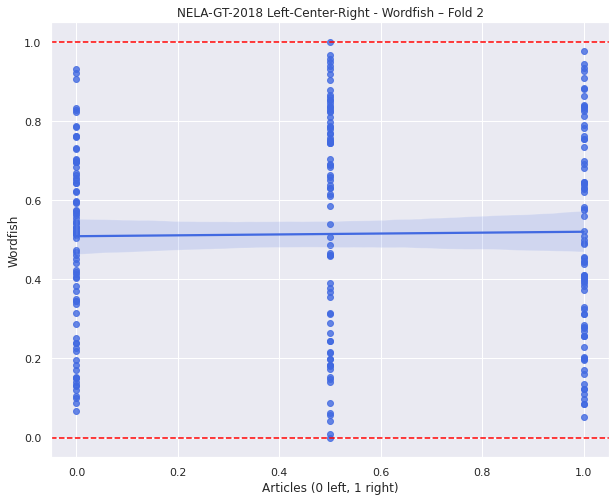

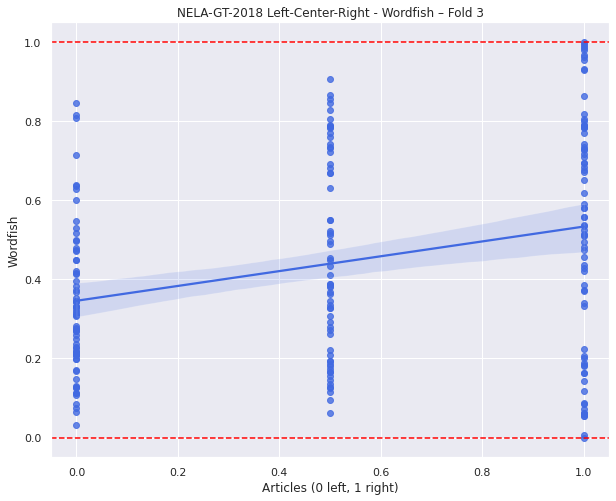

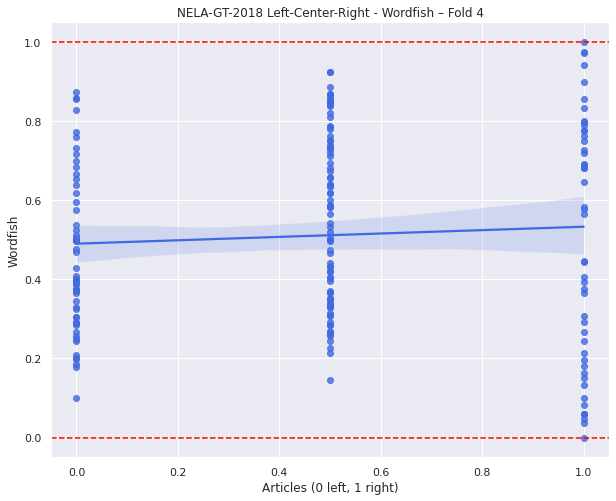

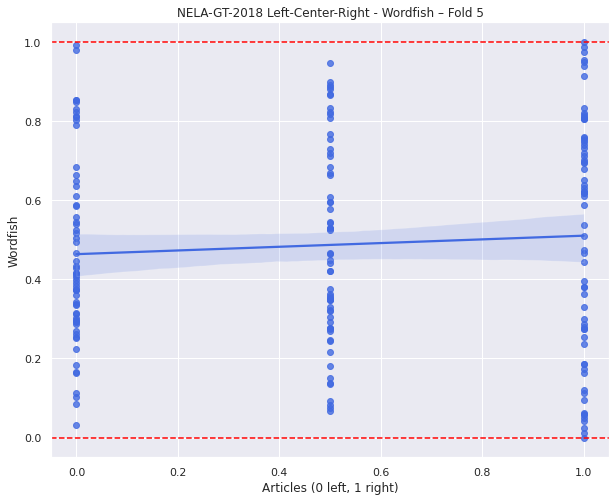

In [46]:
method_name = "Wordfish"
notebook_name = "NELA-GT-2018 Left-Center-Right"
fig_dir = "figs/" + notebook_name  + "/" + method_name + "/"

X = np.array(robjects.r['y_test'])
y = np.array(robjects.r['wf_results_normalized'])
for i in range(num_folds): 
    X[i] = np.array(X[i], dtype = np.float64)
    y[i] = np.array(y[i], dtype = np.float64)

if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)
for i in range(num_folds):
    sns.set(rc={'figure.figsize':(10,8)})
    fig = sns.regplot(x=X[i], y=y[i], color="royalblue")
    fig.set_xlim(-0.05,1.05) # So points aren't cut off on the sides
    plt.axhline(1, ls='--', color="red")
    plt.axhline(0, ls='--', color="red")
    fig.set_xlabel("Articles (0 left, 1 right)")
    fig.set_ylabel(method_name)
    fig.set_title(notebook_name + " - " + method_name + " – Fold " + str(i + 1))
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".pdf")
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".svg")
    plt.show()

We extract the metrics for later analysis:

In [47]:
%%R
MSEs_wf <- mapply(mse, wf_results_normalized, y_test)

We also extract Pearson and Spearman correlation:

In [48]:
%%R
cor_p_wf <- mapply(cor, wf_results_normalized, y_test, method="pearson")
cor_s_wf <- mapply(cor, wf_results_normalized, y_test, method="spearman")

In [49]:
MSEs_wf = np.array(robjects.r['MSEs_wf'])
MSEs_df = MSEs_df.append(
            {"method": "Wordfish (ONLY Norm.)",
             "mean":np.mean(MSEs_wf),
             "std":np.std(MSEs_wf)},
            ignore_index=True)

cor_p_wf = np.array(robjects.r['cor_p_wf'])

cor_p_df = cor_p_df.append(
            {"method": "Wordfish (ONLY Norm.)",
             "mean":np.mean(cor_p_wf),
             "std":np.std(cor_p_wf)},
            ignore_index=True)

cor_s_wf = np.array(robjects.r['cor_s_wf'])

cor_s_df = cor_s_df.append(
            {"method": "Wordfish (ONLY Norm.)",
             "mean":np.mean(cor_s_wf),
             "std":np.std(cor_s_wf)},
            ignore_index=True)

## SemScale (semantic method)

SemScale does not need training, thus we immediately input the test data. SemScale cannot be executed easily inside this notebook, as they are separate files published by the authors, supposed to be started via a bash command (which we will do here).

In order to run SemScale, we have to output our data into .txt files, and add a line with "en" to beginning of each text file. SemScale needs this to classify it as an English text.

We add the "en" at the beginning of each data point using the **unprocessed** variables:

In [50]:
%%R
X_test_sem <- list()

for (i in 1:num_folds) {
      X_test_sem[[i]] <- paste("en", X_test[[i]], sep="\n")
  }

We then create the aforementioned .txt files:

In [51]:
%%R
txt_folder = "txts/txts_horne_l_c_r"

In [52]:
%%R
for (i in 1:num_folds) {
  # Create folders for the text files
  folder_for_fold = glue(paste0(txt_folder, "_{i}"))
  dir.create(folder_for_fold)
  # Create text files
  for (j in 1:length(X_test[[i]])){
    if (y_test[[i]][j] == 0) {
      filename = glue(paste0(folder_for_fold, "/left_news_{j}.txt"))
      write.table(X_test_sem[[i]][j], file=filename, row.names = FALSE, col.names=FALSE, quote=FALSE)
    }
    else if (y_test[[i]][j] == 0.5) {
      filename = glue(paste0(folder_for_fold, "/center_news_{j}.txt"))
      write.table(X_test_sem[[i]][j], file=filename, row.names = FALSE, col.names=FALSE, quote=FALSE)
    }
    else if (y_test[[i]][j] == 1) {
      filename = glue(paste0(folder_for_fold, "/right_news_{j}.txt"))
      write.table(X_test_sem[[i]][j], file=filename, row.names = FALSE, col.names=FALSE, quote=FALSE)
    }
    else {
        print("FAIL!")
    }
  }
}

We now call the SemScale script by using the bash console (if you started this notebook via bash, you can see the prints of SemScale in it):

In [53]:
%%R
for (i in 1:num_folds){
  folder_for_fold = glue(paste0(txt_folder, "_{i}"))
  # Execute in bash (Commented out so it doesn't run the process when running the notebook)
  print(glue("Processing fold {i} out of {num_folds}..."))
  # Because R does not support string concatiation via "+" we must take construct the string in parts...
  script_pt1 = glue(paste0("cd SemScale-master && python scaler.py ../", folder_for_fold))
  full_script = full_cmd = glue(paste(script_pt1, "../embeddings_semscale.vec ./../semscale_outputs/semscale_output_horne_l_c_r_{i}.txt"))
  
  if (!skipTraining) {
      system(full_script)
  }
}

Processing fold 1 out of 5...
Processing fold 2 out of 5...
Processing fold 3 out of 5...
Processing fold 4 out of 5...
Processing fold 5 out of 5...


The cell above outputs .csv files including the scores, which we now read back into our notebook:

In [54]:
%%R
sem_outputs <- list()
for (i in 1:num_folds){
  # Read each file
  sem_outputs[[i]] <- read.csv(glue("semscale_outputs/semscale_output_horne_l_c_r_{i}.txt"), sep="\t", header=FALSE)
}

We add back target labels to the output of SemScale, "sem_outputs":

In [55]:
%%R
for (i in 1:num_folds) {
  for (j in seq_along(sem_outputs[[i]][,1])) {
    if (grepl("left", sem_outputs[[i]][j,1])) {
      sem_outputs[[i]][j,3] <- 0
    }
    else if (grepl("center", sem_outputs[[i]][j,1])) {
      sem_outputs[[i]][j,3] <- 0.5
    }
    else if (grepl("right", sem_outputs[[i]][j,1])) {
      sem_outputs[[i]][j,3] <- 1
    }
    else {
      print("Error! Contains unknown leaning.")
      break
    }
  }
}


We plot the SemScale results (just as we did with Wordscores and Wordfish):

In [56]:
%%R
plot_sem_result <- list()
plot_target <- list()
for (i in 1:num_folds) {
    plot_sem_result[[i]] = sem_outputs[[i]][,2]
    plot_target[[i]] = sem_outputs[[i]][,3]
}

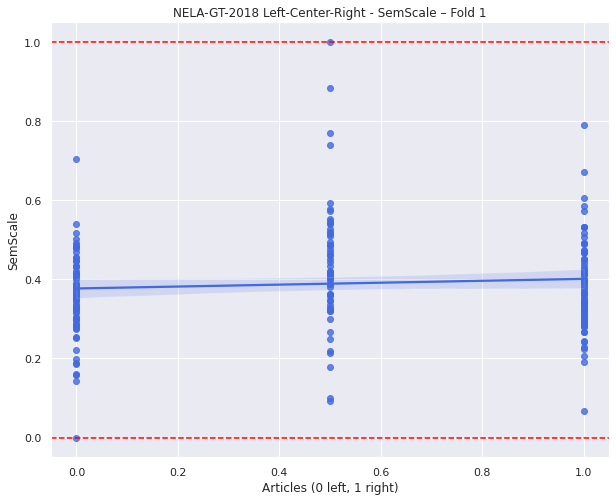

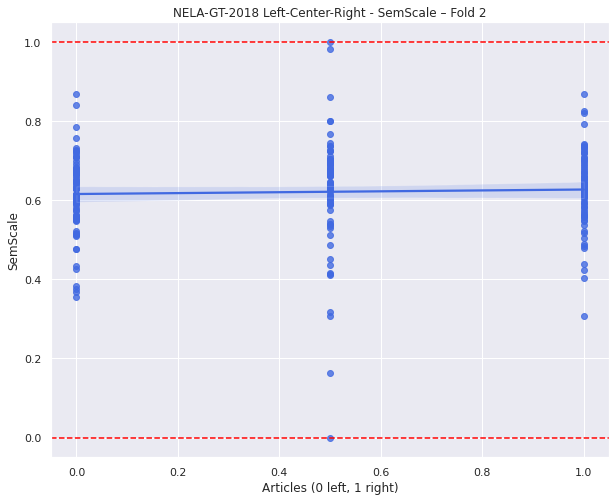

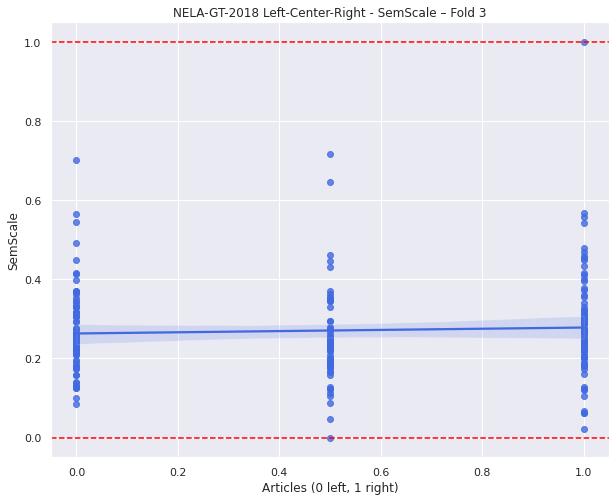

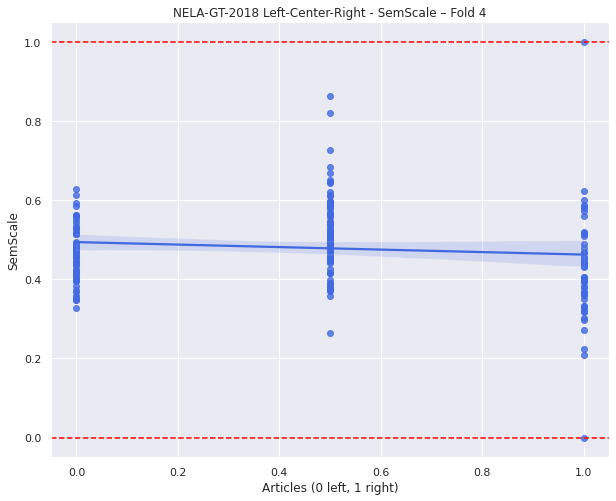

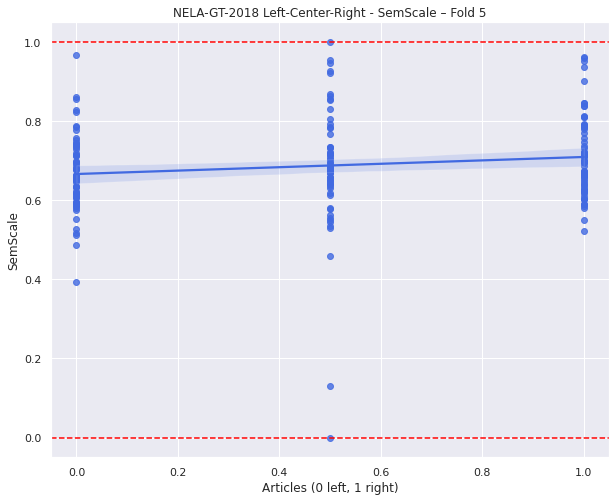

In [57]:
method_name = "SemScale"
notebook_name = "NELA-GT-2018 Left-Center-Right"
fig_dir = "figs/" + notebook_name  + "/" + method_name + "/"

X = np.array(robjects.r['plot_target'])
y = np.array(robjects.r['plot_sem_result'])
for i in range(num_folds): 
    X[i] = np.array(X[i], dtype = np.float64)
    y[i] = np.array(y[i], dtype = np.float64)

if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)
for i in range(num_folds):
    sns.set(rc={'figure.figsize':(10,8)})
    fig = sns.regplot(x=X[i], y=y[i], color="royalblue")
    fig.set_xlim(-0.05,1.05) # So points aren't cut off on the sides
    plt.axhline(1, ls='--', color="red")
    plt.axhline(0, ls='--', color="red")
    fig.set_xlabel("Articles (0 left, 1 right)")
    fig.set_ylabel(method_name)
    fig.set_title(notebook_name + " - " + method_name + " – Fold " + str(i + 1))
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".svg")
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".pdf")
    plt.show()

We extract the metrics for later analysis:

In [58]:
%%R
MSEs_sem <- c()
cor_p_sem <- c()
cor_s_sem <- c()
for (i in 1:num_folds) {
  MSEs_sem[i] <- (mse(sem_outputs[[i]][,2],sem_outputs[[i]][,3]))
  cor_p_sem[i] <- cor(sem_outputs[[i]][,2],sem_outputs[[i]][,3], method="pearson")
  cor_s_sem[i] <- cor(sem_outputs[[i]][,2],sem_outputs[[i]][,3], method="spearman")
}

In [59]:
MSEs_sem = np.array(robjects.r['MSEs_sem'])
MSEs_df = MSEs_df.append(
            {"method": "SemScale (ONLY Norm.)",
             "mean":np.mean(MSEs_sem),
             "std":np.std(MSEs_sem)},
            ignore_index=True)

cor_p_sem = np.array(robjects.r['cor_p_sem'])

cor_p_df = cor_p_df.append(
            {"method": "SemScale (ONLY Norm.)",
             "mean":np.mean(cor_p_sem),
             "std":np.std(cor_p_sem)},
            ignore_index=True)

cor_s_sem = np.array(robjects.r['cor_s_sem'])

cor_s_df = cor_s_df.append(
            {"method": "SemScale (ONLY Norm.)",
             "mean":np.mean(cor_s_sem),
             "std":np.std(cor_s_sem)},
            ignore_index=True)

# Python Setup
We start by importing the data from R into Python:

We copy over the variable names one by one, and make numpy arrays out of them with the datatype "object" in order to be memory-efficient.

In [60]:
import sqlite3
import pandas as pd
import sklearn
import multiprocessing
import torch
import gc
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import tensorflow as tf
import random as rd
from keras.models import load_model
from simpletransformers.classification import ClassificationModel
from keras.utils import np_utils
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr


# We map the numpy array function over the extracted R variables
# in order to get the arrays inside as well as compatiblity with Python

# We specify object as the dtype in order to save memory

X_train = np.array([np.array(k, dtype=object) for k in robjects.r('X_train')])
y_train = np.array([np.array(k, dtype=object) for k in robjects.r('y_train')])

X_test = np.array([np.array(k, dtype=object) for k in robjects.r('X_test')])
y_test = np.array([np.array(k, dtype=object) for k in robjects.r('y_test')])

X_train_processed = np.array([np.array(k, dtype=object) for k in robjects.r('X_train_processed')])

X_test_processed = np.array([np.array(k, dtype=object) for k in robjects.r('X_test_processed')])



# We set some seeds for reproducable results of our methods using random methods


os.environ['PYTHONHASHSEED']=str(42)
rd.seed(42)
np.random.seed(42)
tf.random.set_seed(42)



wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.



## BERT (semantic method)


We now run BERT across all folds:

In [61]:
# Initialize predictions array
predictions = []

# Go over every fold
for i in range(num_folds):
    # We use the garbage collection and cache clearing
    # to not cause errors by the GPU memory being filled up
    print("Fold", i+1, "out of", num_folds)
    print("Freed memory:", gc.collect())
    torch.cuda.empty_cache()
    
    if skipTraining:
        
        model = ClassificationModel('bert', models_folder +'/bert_model_' + str(i) ,num_labels=1,
                                    use_cuda = useGPU,
                                    args={'overwrite_output_dir': True,
                                          "save_model_every_epoch": False,
                                          #'output_dir' : './models/bert_model_' + str(i),
                                          "regression": True,
                                          'num_train_epochs': 3,
                                          #"train_batch_size": 45,
                                          #"evaluate_during_training": True,
                                          #"evaluate_during_training_steps": 50,
                                          "fp16": False})
        
    else: # If no trained models exist, train them
        
        model = ClassificationModel('bert', 'bert-base-uncased',num_labels=1,
                            use_cuda = useGPU,
                            args={'overwrite_output_dir': True,
                                  "save_model_every_epoch": False,
                                  'output_dir' : models_folder + '/bert_model_' + str(i),
                                  "regression": True,
                                  'num_train_epochs': 3,
                                  "train_batch_size": 45,
                                  #"evaluate_during_training": True,
                                  #"evaluate_during_training_steps": 50,
                                  "fp16": False})

        # BERT requires us to concatinate training data and labels
        bert_train_df = pd.concat([pd.DataFrame(X_train[i]), pd.DataFrame(y_train[i])], axis=1)
        # We do the same for the evaluation data we check the validation loss with while training
        #bert_eval_df = pd.concat([pd.DataFrame(X_test[i]), pd.DataFrame(y_test[i])], axis=1)
        # We train the model
        #model.train_model(bert_train_df, eval_df=bert_eval_df)
        model.train_model(bert_train_df)
        
    predictions.append(model.predict(X_test[i])[0])
    
# Free up memory
#del model
print("Freed memory:", gc.collect())
torch.cuda.empty_cache()

Fold 1 out of 5
Freed memory: 74



Fold 2 out of 5
Freed memory: 20



Fold 3 out of 5
Freed memory: 20



Fold 4 out of 5
Freed memory: 20



Fold 5 out of 5
Freed memory: 20



Freed memory: 20


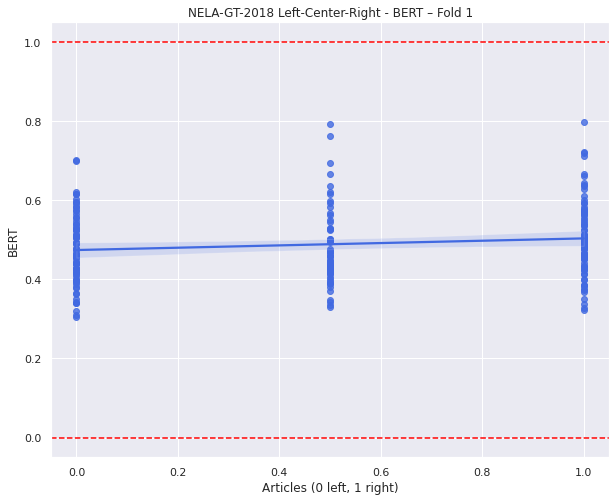

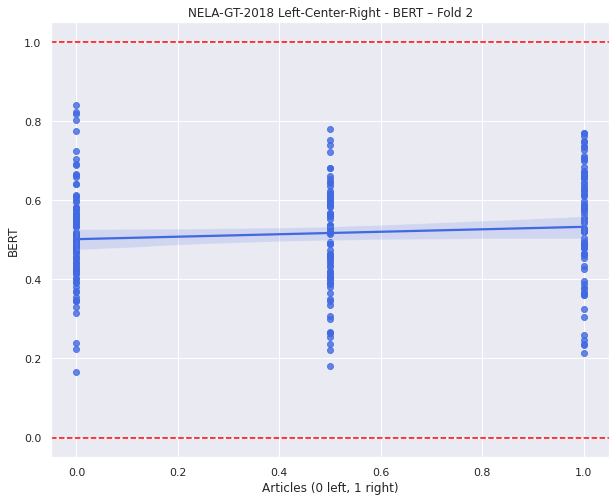

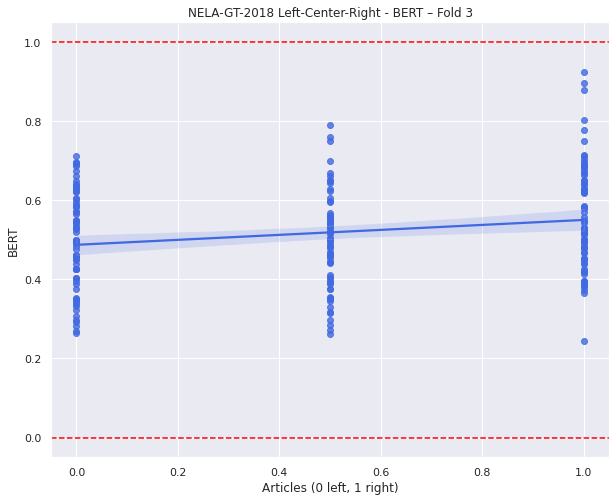

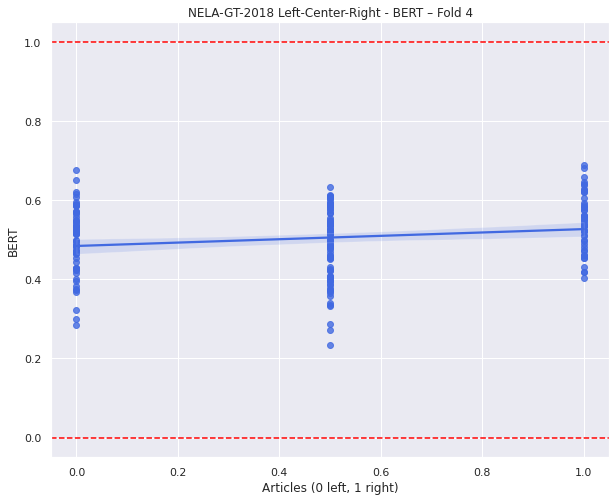

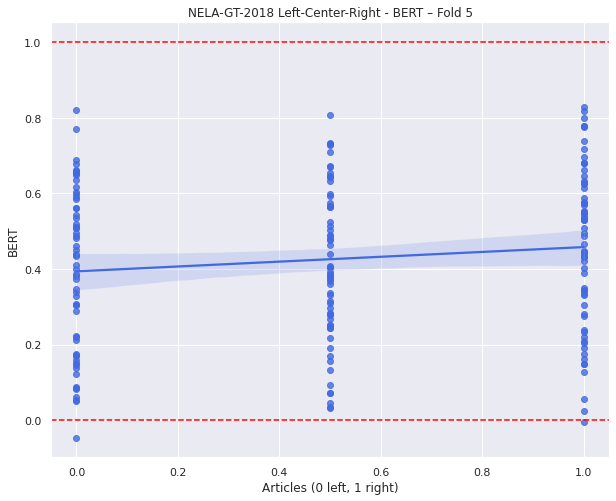

In [62]:
# Plot of the results
method_name = "BERT"
notebook_name = "NELA-GT-2018 Left-Center-Right"
fig_dir = "figs/" + notebook_name  + "/" + method_name + "/"

for i in range(num_folds): 
    X[i] = np.array(y_test[i], dtype = np.float64)
    y[i] = np.array(predictions[i], dtype = np.float64)

if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)
for i in range(num_folds):
    sns.set(rc={'figure.figsize':(10,8)})
    fig = sns.regplot(x=X[i], y=y[i], color="royalblue")
    fig.set_xlim(-0.05,1.05) # So points aren't cut off on the sides
    plt.axhline(1, ls='--', color="red")
    plt.axhline(0, ls='--', color="red")
    fig.set_xlabel("Articles (0 left, 1 right)")
    fig.set_ylabel(method_name)
    fig.set_title(notebook_name + " - " + method_name + " – Fold " + str(i + 1))
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".svg")
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".pdf")
    plt.show()

We extract the metrics for later analysis:


In [63]:
MSEs_bert = list(map(mean_squared_error, predictions, y_test))

from sklearn.preprocessing import MinMaxScaler
predictions_norm = list()
for pred in predictions:
    
    scaler = MinMaxScaler()
    predictions_norm.append(scaler.fit_transform(pred.reshape(-1,1)))
    

# The implementations of the correlations require some array reshpaing
for x in range(num_folds):
    predictions[x] = predictions[x].flatten()
    
# The implementations of the correlations require some array reshpaing
for x in range(num_folds):
    predictions_norm[x] = predictions_norm[x].flatten()

    
MSEs_bert_norm = list(map(mean_squared_error, predictions_norm, y_test))

cor_p_bert = list(map(pearsonr, predictions, y_test))
cor_p_bert_norm = list(map(pearsonr, predictions_norm, y_test))

cor_s_bert = list(map(spearmanr, predictions, y_test)) 
cor_s_bert_norm = list(map(spearmanr, predictions_norm, y_test))    


MSEs_df = MSEs_df.append(
            {"method": "BERT",
             "mean":np.mean(MSEs_bert),
             "std":np.std(MSEs_bert)},
            ignore_index=True)

cor_p_df = cor_p_df.append(
            {"method": "BERT",
             "mean":np.mean(cor_p_bert),
             "std":np.std(cor_p_bert)},
            ignore_index=True)

cor_s_df = cor_s_df.append(
            {"method": "BERT",
             "mean":np.mean(cor_s_bert_norm),
             "std":np.std(cor_s_bert_norm)},
            ignore_index=True)

MSEs_df = MSEs_df.append(
            {"method": "BERT (Norm.)",
             "mean":np.mean(MSEs_bert_norm),
             "std":np.std(MSEs_bert_norm)},
            ignore_index=True)

cor_p_df = cor_p_df.append(
            {"method": "BERT (Norm.)",
             "mean":np.mean(cor_p_bert_norm),
             "std":np.std(cor_p_bert_norm)},
            ignore_index=True)

cor_s_df = cor_s_df.append(
            {"method": "BERT (Norm.)",
             "mean":np.mean(cor_s_bert_norm),
             "std":np.std(cor_s_bert_norm)},
            ignore_index=True)

We define a plotting function to plot the training progress of some methods:

In [64]:
def plot_history(history):
    mse = history.history['mse']
    val_mse = history.history['val_mse']
    x = range(1, len(mse) + 1)

    #plt.figure(figsize=(12, 5))
    plt.plot(x, mse, 'b', label='Training MSE')
    plt.plot(x, val_mse, 'r', label='Validation MSE')
    plt.title('Training and validation MSE')
    plt.legend()
    plt.show()


### Linear Regression with Token Counts (frequency method)

We use **count vectorization** by sklean to create matrices of vectors which contain token frequencies per document, basically like the document-feature matrices by Quanteda we used in R (bag-of-words model).

Since this is one of our word frequency methods, we use the **processed** data:

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
cv_X_train = []
cv_X_test = []

for i in range(num_folds):
    vectorizer = CountVectorizer()
    vectorizer.fit(X_train_processed[i])
    cv_X_train.append(vectorizer.transform(X_train_processed[i]))
    cv_X_test.append(vectorizer.transform(X_test_processed[i]))

We apply **linear regression** to the just created token count data and then min-max scale the outcome to the 0 to 1 range:

In [66]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
predictions = []

for i in range(num_folds):
    print("Fold", i+1, "out of", num_folds)
    # Calculate linear regression, this method is deterministic
    classifier = LinearRegression()
    classifier.fit(cv_X_train[i], y_train[i]) 
    prediction = classifier.predict(cv_X_test[i])
    # Append scaled prediction
    predictions.append(prediction)

#del classifier # Free up memory
print("Freed memory:", gc.collect())

Fold 1 out of 5
Fold 2 out of 5
Fold 3 out of 5
Fold 4 out of 5
Fold 5 out of 5
Freed memory: 13102


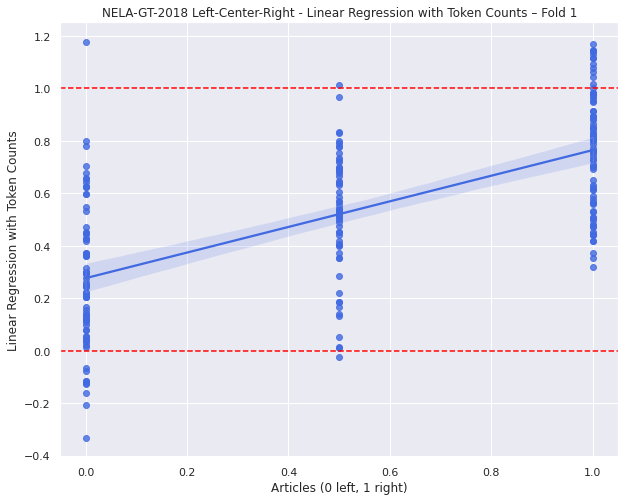

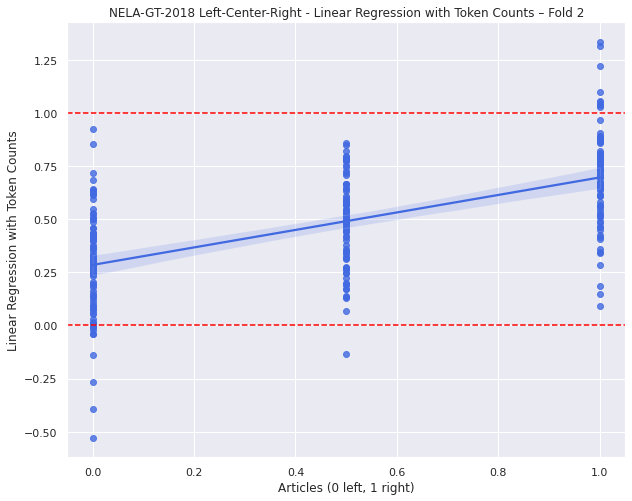

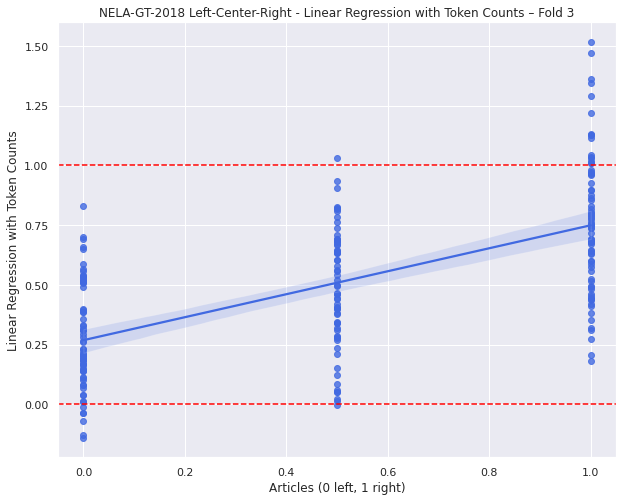

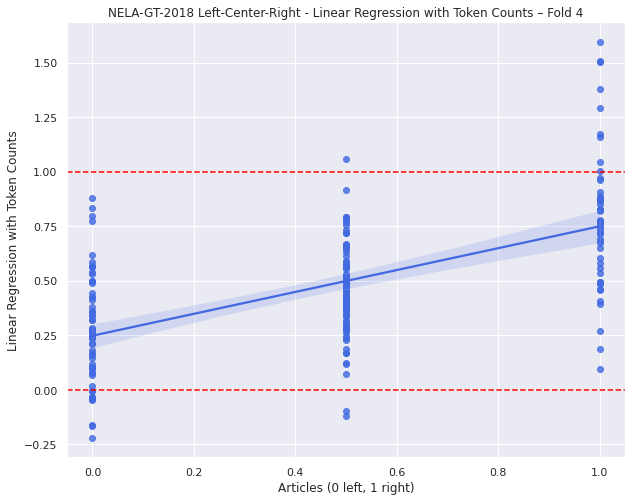

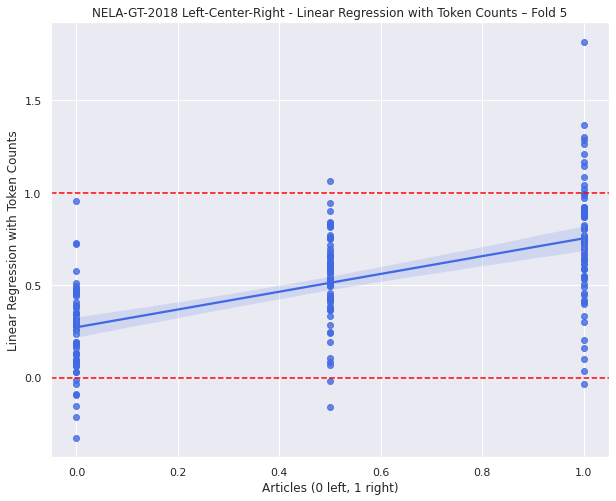

In [67]:
method_name = "Linear Regression with Token Counts"
notebook_name = "NELA-GT-2018 Left-Center-Right"
fig_dir = "figs/" + notebook_name  + "/" + method_name + "/"

for i in range(num_folds): 
    X[i] = np.array(y_test[i], dtype = np.float64)
    y[i] = np.array(predictions[i], dtype = np.float64)

if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)
for i in range(num_folds):
    sns.set(rc={'figure.figsize':(10,8)})
    fig = sns.regplot(x=X[i], y=y[i], color="royalblue")
    fig.set_xlim(-0.05,1.05) # So points aren't cut off on the sides
    plt.axhline(1, ls='--', color="red")
    plt.axhline(0, ls='--', color="red")
    fig.set_xlabel("Articles (0 left, 1 right)")
    fig.set_ylabel(method_name)
    fig.set_title(notebook_name + " - " + method_name + " – Fold " + str(i + 1))
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".svg")
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".pdf")
    plt.show()

We extract the metrics for later analysis:

In [68]:
MSEs_lin_reg_cv = list(map(mean_squared_error, predictions, y_test))
MSEs_lin_reg_cv_norm = list(map(mean_squared_error, predictions_norm, y_test))

predictions_norm = list()
for pred in predictions:
    
    scaler = MinMaxScaler()
    predictions_norm.append(scaler.fit_transform(pred.reshape(-1,1)))

# The implementations of the correlations require some array reshpaing
for x in range(num_folds):
    predictions[x] = predictions[x].flatten()
    
# The implementations of the correlations require some array reshpaing
for x in range(num_folds):
    predictions_norm[x] = predictions_norm[x].flatten()



cor_p_lin_reg_cv = list(map(pearsonr, predictions, y_test))
cor_p_lin_reg_cv_norm = list(map(pearsonr, predictions_norm, y_test))    

cor_s_lin_reg_cv = list(map(spearmanr, predictions, y_test))
cor_s_lin_reg_cv_norm = list(map(spearmanr, predictions_norm, y_test))

MSEs_df = MSEs_df.append(
            {"method": "Linear Regression Token Counts",
             "mean":np.mean(MSEs_lin_reg_cv),
             "std":np.std(MSEs_lin_reg_cv)},
            ignore_index=True)

cor_p_df = cor_p_df.append(
            {"method": "Linear Regression Token Counts",
             "mean":np.mean(cor_p_lin_reg_cv),
             "std":np.std(cor_p_lin_reg_cv)},
            ignore_index=True)

cor_s_df = cor_s_df.append(
            {"method": "Linear Regression Token Counts",
             "mean":np.mean(cor_s_lin_reg_cv),
             "std":np.std(cor_s_lin_reg_cv)},
            ignore_index=True)

MSEs_df = MSEs_df.append(
            {"method": "Linear Regression Token Counts (Norm.)",
             "mean":np.mean(MSEs_lin_reg_cv_norm),
             "std":np.std(MSEs_lin_reg_cv_norm)},
            ignore_index=True)

cor_p_df = cor_p_df.append(
            {"method": "Linear Regression Token Counts (Norm.)",
             "mean":np.mean(cor_p_lin_reg_cv_norm),
             "std":np.std(cor_p_lin_reg_cv_norm)},
            ignore_index=True)

cor_s_df = cor_s_df.append(
            {"method": "Linear Regression Token Counts (Norm.)",
             "mean":np.mean(cor_s_lin_reg_cv_norm),
             "std":np.std(cor_s_lin_reg_cv_norm)},
            ignore_index=True)

### Feed-Forward Neural Network with Token Counts (frequency method)

We now prepare the dataset for the feed-forward neural network.

As we can see, the data we used before is stored as a sparse matrix:

In [69]:
cv_X_train[0]

<836x18849 sparse matrix of type '<class 'numpy.int64'>'
	with 303660 stored elements in Compressed Sparse Row format>

We thus first transform it to arrays, which Keras can work with:

In [70]:

import scipy
# Initialize arrays for neural network data
nn_cv_X_train= []
nn_cv_X_test = []

for i in range(num_folds):
    # Transform to arrays compatible with neural networks
    nn_cv_X_train.append(scipy.sparse.csr_matrix.toarray(cv_X_train[i]))
    nn_cv_X_test.append(scipy.sparse.csr_matrix.toarray(cv_X_test[i]))


We feed to data we just transformed into the array format into a feed-forward neural network:

In [71]:
from keras.models import Sequential
from keras import layers

predictions = []

for i in range(num_folds):

    print("Fold", i+1, "out of", num_folds)
    if skipTraining:
        model = load_model(models_folder +'/ff_tc_' + str(i))
    else: 
        # We create a sequential model
        model = Sequential()
        # We add a first layer, a hidden layer, and an output layer
        model.add(layers.Dense(20 ,activation='relu'))
        model.add(layers.Dense(50,activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))

        # We compile the model
        model.compile(loss='mse',
                    optimizer='adam',
                    metrics=['mse'])
        # We save the model's history for plotting
        history = model.fit(np.array(nn_cv_X_train[i], dtype=np.float), np.array(y_train[i], dtype=np.float),
                          epochs=5,
                          verbose=False,
                          validation_data=(np.array(nn_cv_X_test[i], dtype=np.float), np.array(y_test[i], dtype=np.float)),
                          batch_size=30)

        # We plot the history data created above
        plot_history(history)

    # We create predictions on the test data
    predictions.append(model.predict(nn_cv_X_test[i]))

    # Save model files if training is note skipped
    if not skipTraining:
        model.save(models_folder + '/ff_tc_' + str(i))

#del nn_cv_X_train
#del nn_cv_X_test
#del model # Free up memory
print("Freed memory:", gc.collect())

Fold 1 out of 5
Fold 2 out of 5
Fold 3 out of 5
Fold 4 out of 5
Fold 5 out of 5
Freed memory: 22885


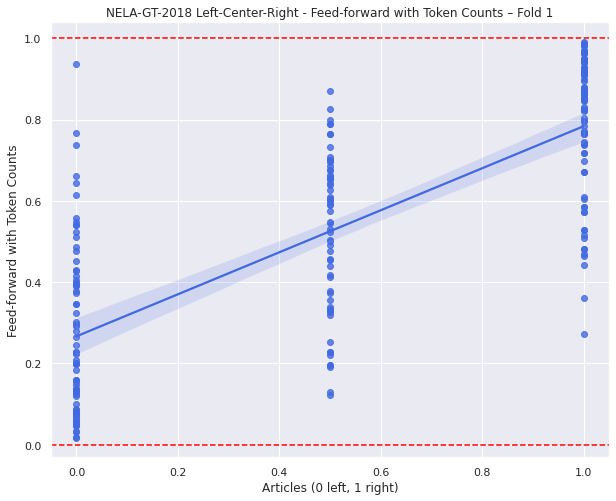

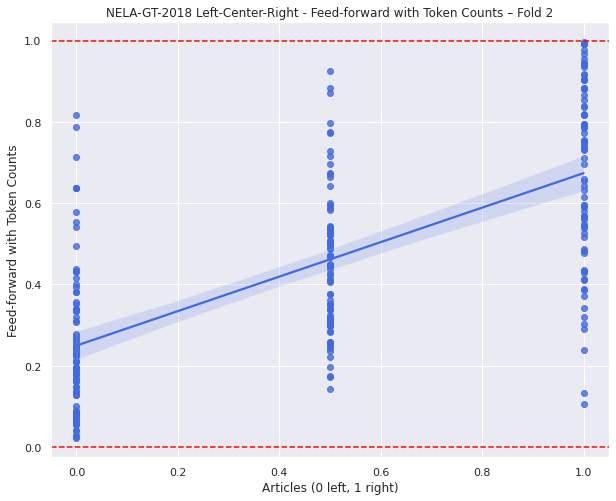

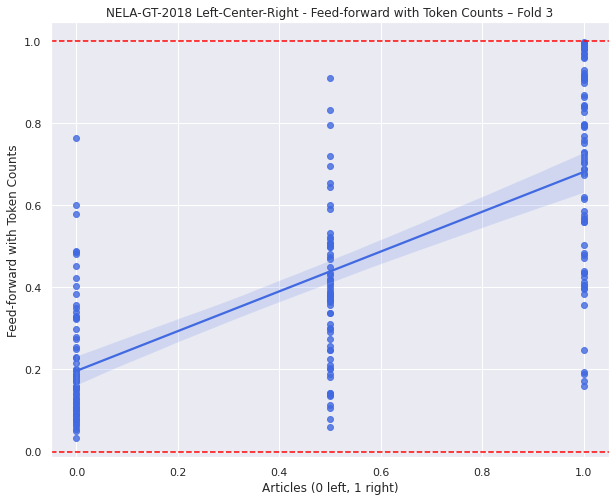

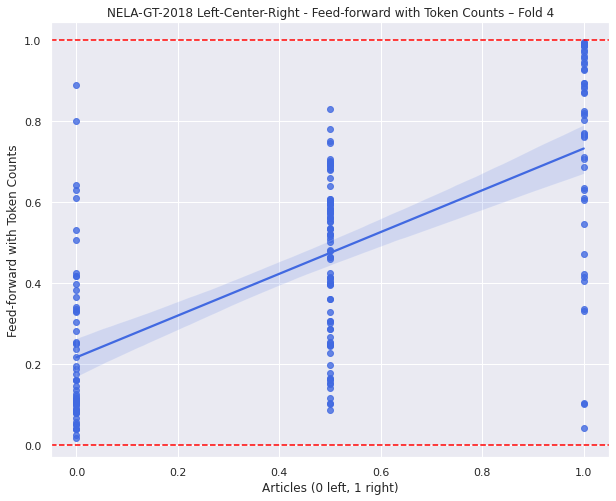

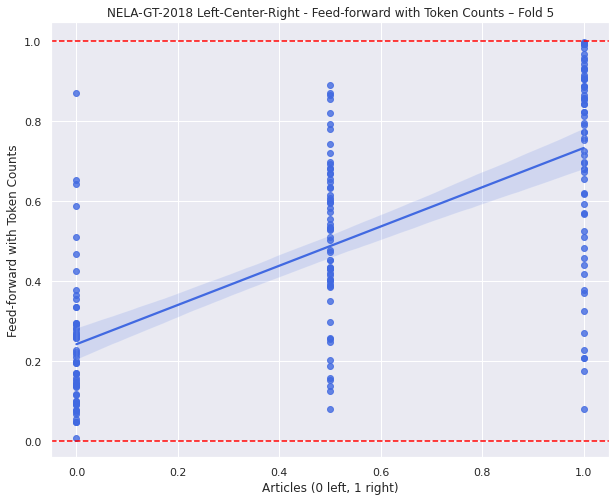

In [72]:
method_name = "Feed-forward with Token Counts"
notebook_name = "NELA-GT-2018 Left-Center-Right"
fig_dir = "figs/" + notebook_name  + "/" + method_name + "/"

for i in range(num_folds): 
    X[i] = np.array(y_test[i], dtype = np.float64)
    y[i] = np.array(predictions[i], dtype = np.float64)

if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)
for i in range(num_folds):
    sns.set(rc={'figure.figsize':(10,8)})
    fig = sns.regplot(x=X[i], y=y[i], color="royalblue")
    fig.set_xlim(-0.05,1.05) # So points aren't cut off on the sides
    plt.axhline(1, ls='--', color="red")
    plt.axhline(0, ls='--', color="red")
    fig.set_xlabel("Articles (0 left, 1 right)")
    fig.set_ylabel(method_name)
    fig.set_title(notebook_name + " - " + method_name + " – Fold " + str(i + 1))
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".svg")
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".pdf")
    plt.show()

We extract the metrics for later analysis:

In [73]:
MSEs_ff_cv = list(map(mean_squared_error, predictions, y_test))

from sklearn.preprocessing import MinMaxScaler
predictions_norm = list()
for pred in predictions:
    
    scaler = MinMaxScaler()
    predictions_norm.append(scaler.fit_transform(pred.reshape(-1,1)))
    

# The implementations of the correlations require some array reshpaing
for x in range(num_folds):
    predictions[x] = predictions[x].flatten()
    
# The implementations of the correlations require some array reshpaing
for x in range(num_folds):
    predictions_norm[x] = predictions_norm[x].flatten()

    
MSEs_ff_cv_norm = list(map(mean_squared_error, predictions_norm, y_test))

cor_p_ff_cv = list(map(pearsonr, predictions, y_test))
cor_p_ff_cv_norm = list(map(pearsonr, predictions_norm, y_test))

cor_s_ff_cv = list(map(spearmanr, predictions, y_test)) 
cor_s_ff_cv_norm = list(map(spearmanr, predictions_norm, y_test))    


MSEs_df = MSEs_df.append(
            {"method": "Feed Forward Token Counts",
             "mean":np.mean(MSEs_ff_cv),
             "std":np.std(MSEs_ff_cv)},
            ignore_index=True)

cor_p_df = cor_p_df.append(
            {"method": "Feed Forward Token Counts",
             "mean":np.mean(cor_p_ff_cv),
             "std":np.std(cor_p_ff_cv)},
            ignore_index=True)

cor_s_df = cor_s_df.append(
            {"method": "Feed Forward Token Counts",
             "mean":np.mean(cor_s_ff_cv_norm),
             "std":np.std(cor_s_ff_cv_norm)},
            ignore_index=True)

MSEs_df = MSEs_df.append(
            {"method": "Feed Forward Token Counts (Norm.)",
             "mean":np.mean(MSEs_ff_cv_norm),
             "std":np.std(MSEs_ff_cv_norm)},
            ignore_index=True)

cor_p_df = cor_p_df.append(
            {"method": "Feed Forward Token Counts (Norm.)",
             "mean":np.mean(cor_p_ff_cv_norm),
             "std":np.std(cor_p_ff_cv_norm)},
            ignore_index=True)

cor_s_df = cor_s_df.append(
            {"method": "Feed Forward Token Counts (Norm.)",
             "mean":np.mean(cor_s_ff_cv_norm),
             "std":np.std(cor_s_ff_cv_norm)},
            ignore_index=True)

Now we create another tokenized version of our data, but this time inside the Keras environment. Later we will create the word embedding matrix from this. Since this will be used for the semantic methods, we use the **unprocessed** data.

We save the fitted tokenizers for each fold into a list named *tokenizers*, also the vocabulary sizes into *vocab_sizes* as we will need these later when we construct our embedding matrix:

In [74]:
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Initialize list of tokenizers
tokenizers = []
# Initiliaze arrays of training data
tok_X_train = []
tok_y_train = []
tok_X_test = []
tok_y_test = []
# Vocabulary sizes
vocab_sizes = []

# As we have 1000 words, we chose to give the tokenized data a maximum length of 1050,
# just to be sure.
maxlen = 1050

for i in range(num_folds):
    # We initialize and fit the tokenizers
    tokenizers.append(Tokenizer())
    tokenizers[i].fit_on_texts(X_train[i])
    tok_X_train.append(tokenizers[i].texts_to_sequences(X_train[i]))
    tok_X_test.append(tokenizers[i].texts_to_sequences(X_test[i]))
    vocab_sizes.append(len(tokenizers[i].word_index) + 1)

    tok_X_train[i] = (pad_sequences(tok_X_train[i], padding='post', maxlen=maxlen))
    tok_X_test[i] = (pad_sequences(tok_X_test[i], padding='post', maxlen=maxlen))
    tok_y_train.append(np_utils.to_categorical(y_train[i]))
    tok_y_test.append(np_utils.to_categorical(y_test[i]))


We make the embedding process more efficient by creating an optimized embedding matrix which only contains the embeddings for the words actually appearing in the text corpus. We define the function which we will call later:

In [75]:
# This function is based on a function from https://realpython.com/python-keras-text-classification/

def create_optimized_embedding_matrix(matrix_file, word_index, embedding_dim, vocab_size):
    vocab_size = len(word_index) + 1
    # Initialize the embedding matrix
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    # We have to add an "en__" prefix to every key, because we analyze English documents
    word_index = {'en__' + key : value for key, value in word_index.items()}
    with open(matrix_file) as f:
        for line in f:
            # Extract the embeddings for every word in the embeddings file
            word, *emb_vector = line.split()
            # Check the word appears in our text corpus
            if word in word_index:
                # We add the corresponding vector of that word to our embedding matrix
                embedding_matrix[word_index[word]] = np.array(emb_vector, dtype=object)[:embedding_dim]
    return embedding_matrix

### Linear Regression with Embeddings (semantic method)

We now apply the function defined above to create an embedding matrix on which we will train linear regression:

In [76]:
embedding_dim = 300 # The embedding matrix contains 300 semantic values for each word

emb_X_train = []
emb_X_test = []

for i in range(num_folds):
    if skipTraining:
        model = load_model(models_folder + '/nn_emb_' + str(i))
    else: 
        # We create the embedding matrix
        print("Creating fold", i+1, "out of", num_folds)
        embedding_matrix = create_optimized_embedding_matrix(
            'embeddings_semscale.vec',
            tokenizers[i].word_index,
            embedding_dim,
            vocab_sizes[i])

        # We use the embedding layer and flatten the results to work with it later
        model = Sequential()
        model.add(layers.Embedding(input_dim=vocab_sizes[i], 
                               output_dim=embedding_dim, 
                               input_length=maxlen,
                               weights=[embedding_matrix],
                               trainable=False))
        model.add(layers.Flatten(trainable=False))
        model.trainable = False
        model.compile('adam', 'mse')
        
        # Save model files
        model.save(models_folder + '/nn_emb_' + str(i))
    # We create the actual embedded training and testing data
    # The term "predict" is misleading here, we merely feed the
    # data through the construct we created in the last lines.
    emb_X_train.append(model.predict(tok_X_train[i]))
    emb_X_test.append(model.predict(tok_X_test[i]))

print("Freed memory:", gc.collect())

Freed memory: 18534


As we can see above, we use Keras in a similar fashion as when we trained the feed-forward neural network, however, this construct here does not contain any trainable parameters. We merely have an embedding layer, which creates our final training and testing data (as we feed it the embedding matrix and our tokenized data). At the end, we have added a flatten layer, in order to flatten the array structure for later work with it.

We apply **linear regression** to the **embedded data** we just created:

In [77]:
from sklearn.linear_model import LinearRegression

predictions = []

for i in range(num_folds):
    print("Fold", i+1, "out of", num_folds)
    # Calculate linear regression, this method is deterministic
    classifier = LinearRegression()
    classifier.fit(emb_X_train[i], y_train[i])  
    predictions.append(classifier.predict(emb_X_test[i]))
#del classifier
print("Freed memory:", gc.collect())
print("DONE!")

Fold 1 out of 5
Fold 2 out of 5
Fold 3 out of 5
Fold 4 out of 5
Fold 5 out of 5
Freed memory: 20
DONE!


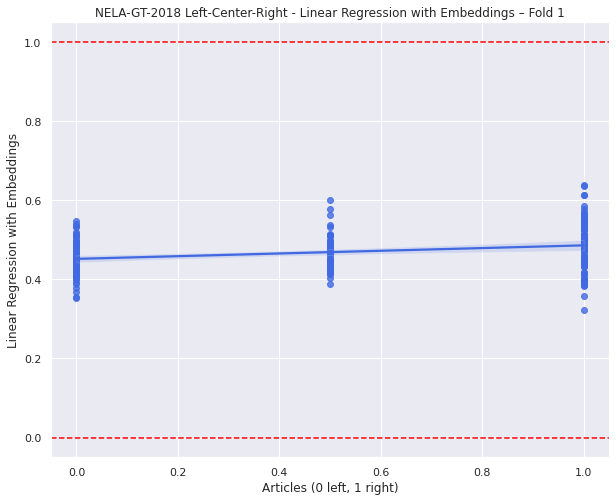

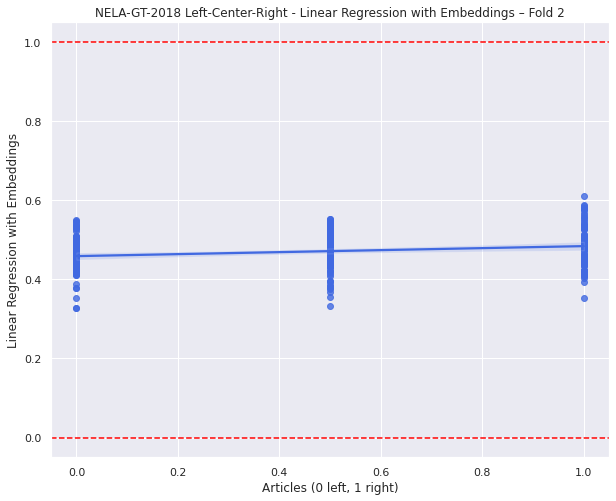

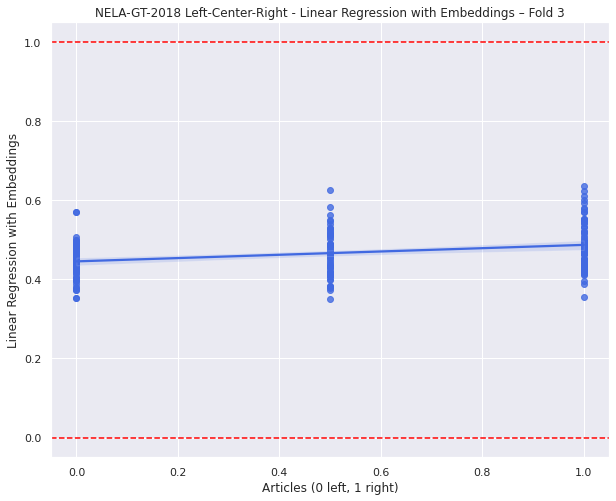

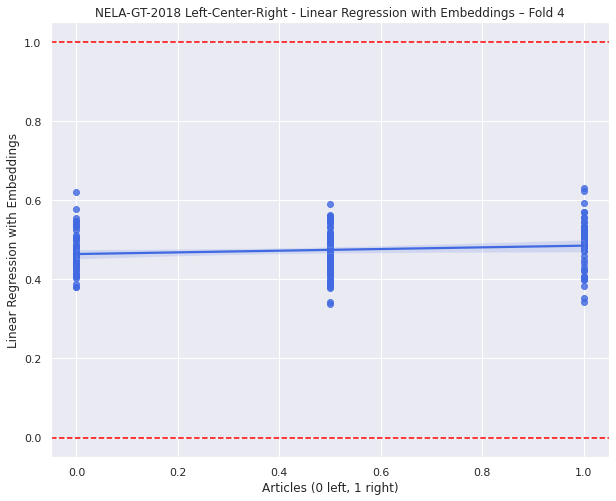

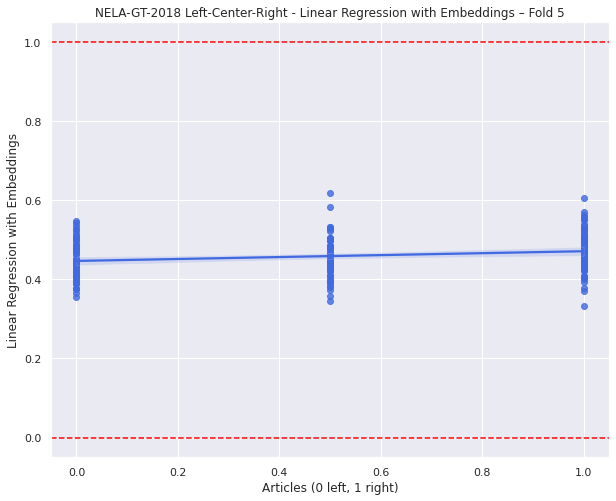

In [78]:
method_name = "Linear Regression with Embeddings"
notebook_name = "NELA-GT-2018 Left-Center-Right"
fig_dir = "figs/" + notebook_name  + "/" + method_name + "/"

for i in range(num_folds): 
    X[i] = np.array(y_test[i], dtype = np.float64)
    y[i] = np.array(predictions[i], dtype = np.float64)

if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)
for i in range(num_folds):
    sns.set(rc={'figure.figsize':(10,8)})
    fig = sns.regplot(x=X[i], y=y[i], color="royalblue")
    fig.set_xlim(-0.05,1.05) # So points aren't cut off on the sides
    plt.axhline(1, ls='--', color="red")
    plt.axhline(0, ls='--', color="red")
    fig.set_xlabel("Articles (0 left, 1 right)")
    fig.set_ylabel(method_name)
    fig.set_title(notebook_name + " - " + method_name + " – Fold " + str(i + 1))
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".svg")
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".pdf")
    plt.show()

We extract the metrics for later analysis:

In [79]:
MSEs_lin_reg_embedding = list(map(mean_squared_error, predictions, y_test))

from sklearn.preprocessing import MinMaxScaler
predictions_norm = list()
for pred in predictions:
    
    scaler = MinMaxScaler()
    predictions_norm.append(scaler.fit_transform(pred.reshape(-1,1)))
    

# The implementations of the correlations require some array reshpaing
for x in range(num_folds):
    predictions[x] = predictions[x].flatten()
    
# The implementations of the correlations require some array reshpaing
for x in range(num_folds):
    predictions_norm[x] = predictions_norm[x].flatten()

    
MSEs_lin_reg_embedding_norm = list(map(mean_squared_error, predictions_norm, y_test))

cor_p_lin_reg_embedding = list(map(pearsonr, predictions, y_test))
cor_p_lin_reg_embedding_norm = list(map(pearsonr, predictions_norm, y_test))

cor_s_lin_reg_embedding = list(map(spearmanr, predictions, y_test)) 
cor_s_lin_reg_embedding_norm = list(map(spearmanr, predictions_norm, y_test))    


MSEs_df = MSEs_df.append(
            {"method": "Linear Regression Embeddings",
             "mean":np.mean(MSEs_lin_reg_embedding),
             "std":np.std(MSEs_lin_reg_embedding)},
            ignore_index=True)

cor_p_df = cor_p_df.append(
            {"method": "Linear Regression Embeddings",
             "mean":np.mean(cor_p_lin_reg_embedding),
             "std":np.std(cor_p_lin_reg_embedding)},
            ignore_index=True)

cor_s_df = cor_s_df.append(
            {"method": "Linear Regression Embeddings",
             "mean":np.mean(cor_s_lin_reg_embedding_norm),
             "std":np.std(cor_s_lin_reg_embedding_norm)},
            ignore_index=True)

MSEs_df = MSEs_df.append(
            {"method": "Linear Regression Embeddings (Norm.)",
             "mean":np.mean(MSEs_lin_reg_embedding_norm),
             "std":np.std(MSEs_lin_reg_embedding_norm)},
            ignore_index=True)

cor_p_df = cor_p_df.append(
            {"method": "Linear Regression Embeddings (Norm.)",
             "mean":np.mean(cor_p_lin_reg_embedding_norm),
             "std":np.std(cor_p_lin_reg_embedding_norm)},
            ignore_index=True)

cor_s_df = cor_s_df.append(
            {"method": "Linear Regression Embeddings (Norm.)",
             "mean":np.mean(cor_s_lin_reg_embedding_norm),
             "std":np.std(cor_s_lin_reg_embedding_norm)},
            ignore_index=True)

### Feed-Forward Neural Network with Embeddings (semantic method)

The same embedded data will be fed to a feed-forward neural network:

In [80]:
predictions = []
histories = []

for i in range(num_folds):
    print("Fold", i+1, "out of", num_folds)
    if skipTraining:
        model = load_model(models_folder + '/ff_emb_' + str(i))
    else: 
        model = Sequential()
        model.add(layers.Dense(20 ,activation='relu'))
        model.add(layers.Dense(50,activation='relu'))    
        model.add(layers.Dense(1, activation='sigmoid'))

        model.compile(loss='mse',
                    optimizer='adam',
                    metrics=['mse'])


        history = model.fit(np.array(emb_X_train[i], dtype=np.float), np.array(y_train[i], dtype=np.float),
                          epochs=15,
                          verbose=True,
                          validation_data=(np.array(emb_X_test[i], dtype=np.float), np.array(y_test[i], dtype=np.float)),
                          batch_size=500)



        plot_history(history)
    
    predictions.append(model.predict(np.array(emb_X_test[i], dtype=np.float)))
    
    
    if not os.path.isfile(models_folder + '/ff_emb_' + str(i)):
        model.save(models_folder + '/ff_emb_' + str(i))


print("Freed memory:", gc.collect())

Fold 1 out of 5
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/models_horne_l_c_r/ff_emb_0/assets
Fold 2 out of 5
INFO:tensorflow:Assets written to: models/models_horne_l_c_r/ff_emb_1/assets
Fold 3 out of 5
INFO:tensorflow:Assets written to: models/models_horne_l_c_r/ff_emb_2/assets
Fold 4 out of 5
INFO:tensorflow:Assets written to: models/models_horne_l_c_r/ff_emb_3/assets
Fold 5 out of 5
INFO:tensorflow:Assets written to: models/models_horne_l_c_r/ff_emb_4/assets
Freed memory: 28097


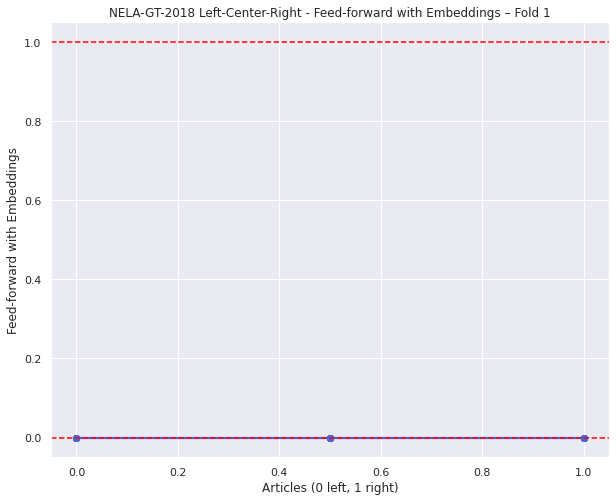

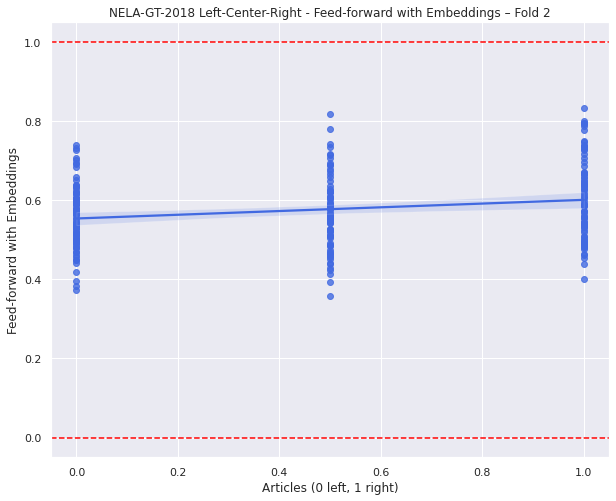

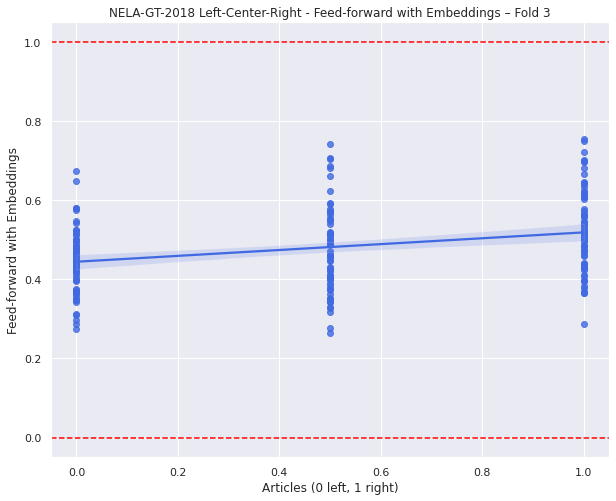

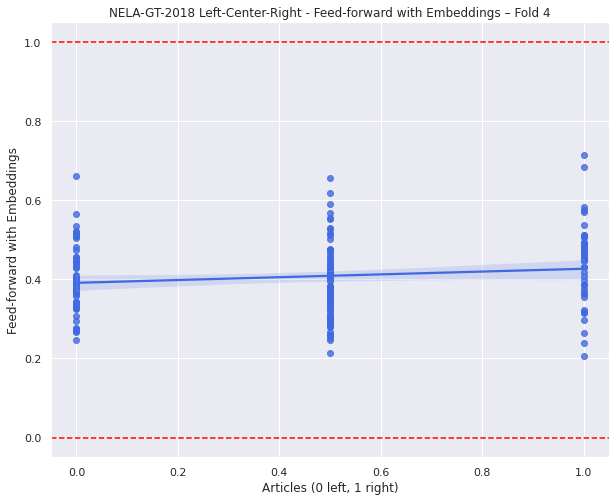

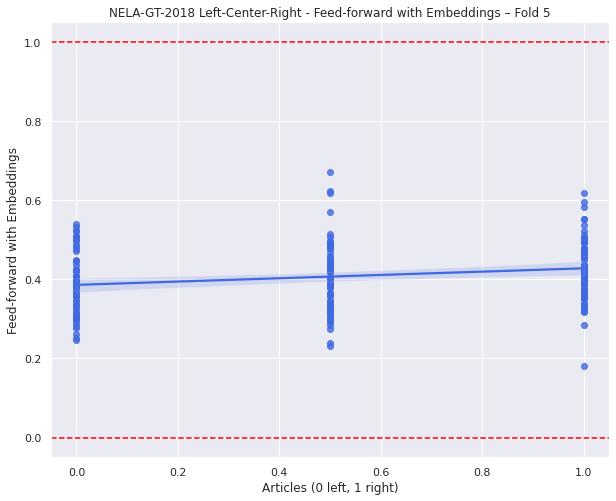

In [81]:
method_name = "Feed-forward with Embeddings"
notebook_name = "NELA-GT-2018 Left-Center-Right"
fig_dir = "figs/" + notebook_name  + "/" + method_name + "/"

for i in range(num_folds): 
    X[i] = np.array(y_test[i], dtype = np.float64)
    y[i] = np.array(predictions[i], dtype = np.float64)

if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)
for i in range(num_folds):
    sns.set(rc={'figure.figsize':(10,8)})
    fig = sns.regplot(x=X[i], y=y[i], color="royalblue")
    fig.set_xlim(-0.05,1.05) # So points aren't cut off on the sides
    plt.axhline(1, ls='--', color="red")
    plt.axhline(0, ls='--', color="red")
    fig.set_xlabel("Articles (0 left, 1 right)")
    fig.set_ylabel(method_name)
    fig.set_title(notebook_name + " - " + method_name + " – Fold " + str(i + 1))
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".svg")
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".pdf")
    plt.show()

We extract the metrics for later analysis:

In [82]:
MSEs_ff_embedding = list(map(mean_squared_error, predictions, y_test))

from sklearn.preprocessing import MinMaxScaler
predictions_norm = list()
for pred in predictions:
    
    scaler = MinMaxScaler()
    predictions_norm.append(scaler.fit_transform(pred.reshape(-1,1)))
    

# The implementations of the correlations require some array reshpaing
for x in range(num_folds):
    predictions[x] = predictions[x].flatten()
    
# The implementations of the correlations require some array reshpaing
for x in range(num_folds):
    predictions_norm[x] = predictions_norm[x].flatten()

    
MSEs_ff_embedding_norm = list(map(mean_squared_error, predictions_norm, y_test))

cor_p_ff_embedding = list(map(pearsonr, predictions, y_test))
cor_p_ff_embedding_norm = list(map(pearsonr, predictions_norm, y_test))

cor_s_ff_embedding = list(map(spearmanr, predictions, y_test)) 
cor_s_ff_embedding_norm = list(map(spearmanr, predictions_norm, y_test))    


MSEs_df = MSEs_df.append(
            {"method": "Feed Forward Embeddings",
             "mean":np.mean(MSEs_ff_embedding),
             "std":np.std(MSEs_ff_embedding)},
            ignore_index=True)

cor_p_df = cor_p_df.append(
            {"method": "Feed Forward Embeddings",
             "mean":np.mean(cor_p_ff_embedding),
             "std":np.std(cor_p_ff_embedding)},
            ignore_index=True)

cor_s_df = cor_s_df.append(
            {"method": "Feed Forward Embeddings",
             "mean":np.mean(cor_s_ff_embedding_norm),
             "std":np.std(cor_s_ff_embedding_norm)},
            ignore_index=True)

MSEs_df = MSEs_df.append(
            {"method": "Feed Forward Embeddings (Norm.)",
             "mean":np.mean(MSEs_ff_embedding_norm),
             "std":np.std(MSEs_ff_embedding_norm)},
            ignore_index=True)

cor_p_df = cor_p_df.append(
            {"method": "Feed Forward Embeddings (Norm.)",
             "mean":np.mean(cor_p_ff_embedding_norm),
             "std":np.std(cor_p_ff_embedding_norm)},
            ignore_index=True)

cor_s_df = cor_s_df.append(
            {"method": "Feed Forward Embeddings (Norm.)",
             "mean":np.mean(cor_s_ff_embedding_norm),
             "std":np.std(cor_s_ff_embedding_norm)},
            ignore_index=True)

## Final Results

We now plot the **MSEs**:

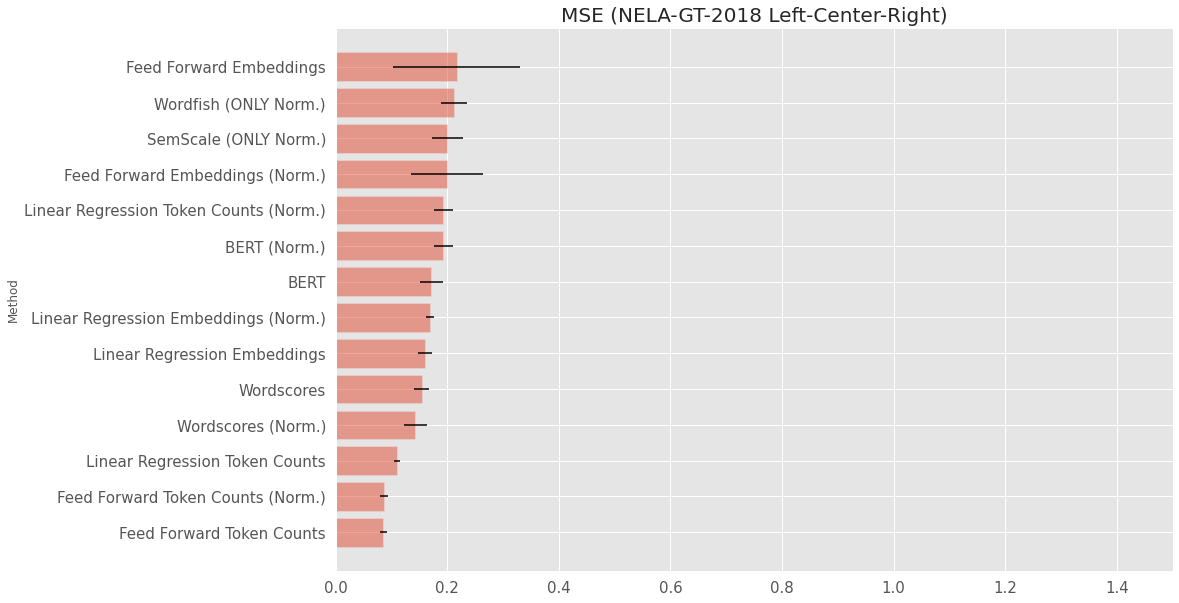

In [83]:
from matplotlib import pyplot as plt

MSEs_df = MSEs_df.sort_values(by="mean", ascending=True)
MSEs_df.reset_index(drop=True, inplace=True)

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15,10))
ax.barh(MSEs_df["method"], MSEs_df["mean"], xerr=MSEs_df["std"], align='center', alpha=0.5, ecolor='black')
ax.set_ylabel('Method')
ax.set_title('MSE (NELA-GT-2018 Left-Center-Right)', fontsize=20)
ax.tick_params(labelsize=15, labelrotation=0)
ax.yaxis.grid(True)
ax.set_xlim(0, 1.5)

notebook_name = "NELA-GT-2018 Left-Center-Right"
fig_dir = "figs/" + notebook_name + "/"
fig.savefig(fig_dir + "MSEs.svg", bbox_inches='tight')
fig.savefig(fig_dir + "MSEs.pdf", bbox_inches='tight')

Now the **pearson correlations**:

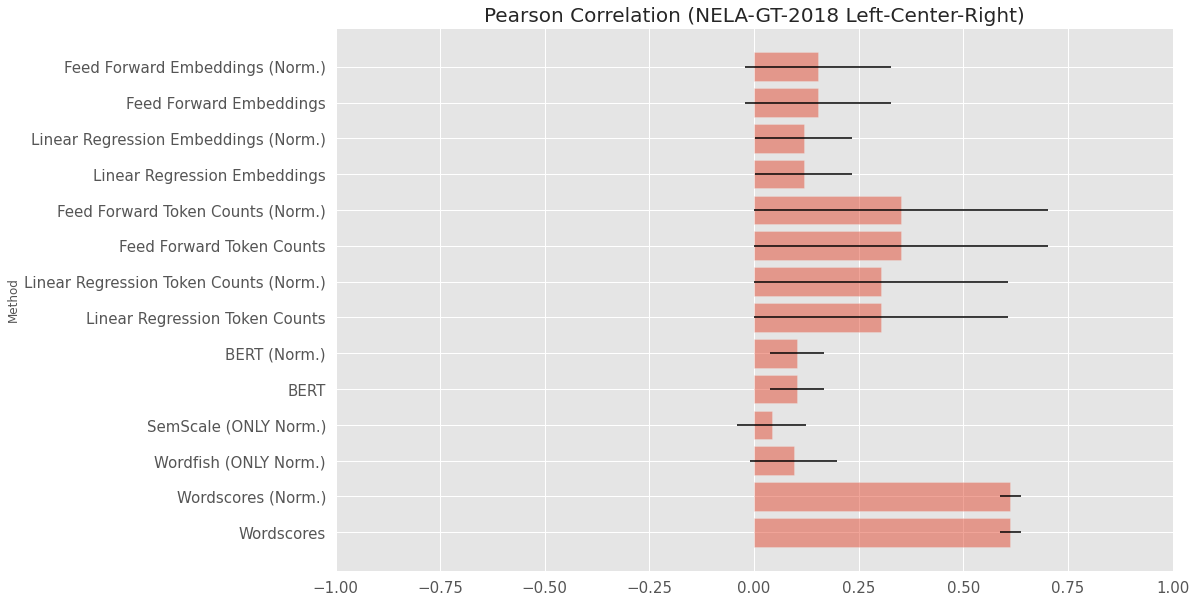

In [84]:
from matplotlib import pyplot as plt

MSEs_df = MSEs_df.sort_values(by="mean", ascending=True)
MSEs_df.reset_index(drop=True, inplace=True)

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15,10))
ax.barh(cor_p_df["method"], cor_p_df["mean"], xerr=cor_p_df["std"], align='center', alpha=0.5, ecolor='black')
ax.set_ylabel('Method')
ax.set_title('Pearson Correlation (NELA-GT-2018 Left-Center-Right)', fontsize=20)
ax.tick_params(labelsize=15, labelrotation=0)
ax.yaxis.grid(True)
ax.set_xlim(-1,1)

notebook_name = "NELA-GT-2018 Left-Center-Right"
fig_dir = "figs/" + notebook_name + "/"
fig.savefig(fig_dir + "cor_p.svg", bbox_inches='tight')
fig.savefig(fig_dir + "cor_p.pdf", bbox_inches='tight')

Now the **spearman correlations**:

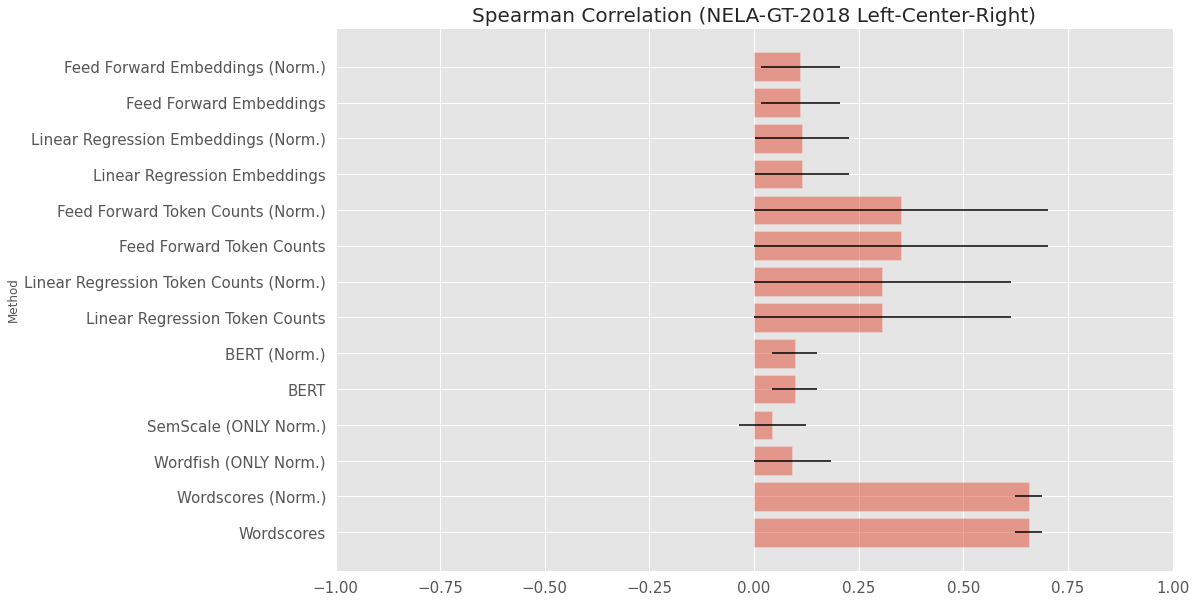

In [85]:
from matplotlib import pyplot as plt

MSEs_df = MSEs_df.sort_values(by="mean", ascending=True)
MSEs_df.reset_index(drop=True, inplace=True)

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15,10))
ax.barh(cor_s_df["method"], cor_s_df["mean"], xerr=cor_s_df["std"], align='center', alpha=0.5, ecolor='black')
ax.set_ylabel('Method')
ax.set_title('Spearman Correlation (NELA-GT-2018 Left-Center-Right)', fontsize=20)
ax.tick_params(labelsize=15, labelrotation=0)
ax.yaxis.grid(True)
ax.set_xlim(-1,1)

notebook_name = "NELA-GT-2018 Left-Center-Right"
fig_dir = "figs/" + notebook_name + "/"
fig.savefig(fig_dir + "cor_s.svg", bbox_inches='tight')
fig.savefig(fig_dir + "cor_s.pdf", bbox_inches='tight')

We show the final **MSEs** in a table:

In [86]:
# Save results
if not os.path.exists("./results/horne_l_c_r"):
    os.makedirs("./results/horne_l_c_r")
MSEs_df.to_csv("./results/horne_l_c_r/MSEs.csv", index=False)
MSEs_df

,method,mean,std
0,Feed Forward Token Counts,0.085404,0.006490
1,Feed Forward Token Counts (Norm.),0.086175,0.007076
2,Linear Regression Token Counts,0.110094,0.006090
3,Wordscores (Norm.),0.142841,0.020334
4,Wordscores,0.154300,0.013253
5,Linear Regression Embeddings,0.160290,0.012574
6,Linear Regression Embeddings (Norm.),0.169354,0.006925
7,BERT,0.171611,0.020303
8,BERT (Norm.),0.192989,0.016748
9,Linear Regression Token Counts (Norm.),0.192989,0.016748


We show the final **pearson correlations** in a table:

In [87]:
cor_p_df.to_csv("results/horne_l_c_r/cor_p.csv", index=False)
cor_p_df

,method,mean,std
0,Wordscores,0.612616,0.025674
1,Wordscores (Norm.),0.612616,0.025674
2,Wordfish (ONLY Norm.),0.094594,0.103774
3,SemScale (ONLY Norm.),0.041802,0.083095
4,BERT,0.103104,0.063873
5,BERT (Norm.),0.103104,0.063873
6,Linear Regression Token Counts,0.302847,0.303299
7,Linear Regression Token Counts (Norm.),0.302847,0.303299
8,Feed Forward Token Counts,0.350874,0.351553
9,Feed Forward Token Counts (Norm.),0.350874,0.351553


We show the final **spearman correlations** in a table:

In [88]:
cor_s_df.to_csv("results/horne_l_c_r/cor_s.csv", index=False)
cor_s_df

,method,mean,std
0,Wordscores,0.656143,0.031580
1,Wordscores (Norm.),0.656143,0.031580
2,Wordfish (ONLY Norm.),0.090843,0.092010
3,SemScale (ONLY Norm.),0.043861,0.080819
4,BERT,0.096651,0.052998
5,BERT (Norm.),0.096651,0.052998
6,Linear Regression Token Counts,0.306367,0.306836
7,Linear Regression Token Counts (Norm.),0.306367,0.306836
8,Feed Forward Token Counts,0.350666,0.351427
9,Feed Forward Token Counts (Norm.),0.350666,0.351427


In [89]:
# We now combine the metrics and 
# append them to the file 'results/all_metrics.csv'
# which we use to store the metrics of all the notebooks

# First, we transform the metrics dataframes in order to
# keep the information which numbers represent which metrics
# and from which notebook they are coming from.
# That way we can later access
# that information in the 'results/all_metrics.csv' file

new_MSEs_df = MSEs_df.set_index("method").transpose().rename(index={"mean": "MSE (Avg) " + \
                notebook_name, \
                "std":  "MSE (Std) " + notebook_name})

                

new_cor_p_df = cor_p_df.set_index("method").transpose().rename(index={"mean": "Pearson Corr. (Avg) " + \
                notebook_name, \
                "std":  "Pearson Corr. (Std) " + notebook_name})



new_cor_s_df = cor_s_df.set_index("method").transpose().rename(index={"mean": "Spearman Corr. (Avg) " + \
                notebook_name, \
                "std":  "Spearman Corr. (Std) " + notebook_name})


# We combine all the metrics
combined_metrics = new_MSEs_df.append([new_cor_p_df,new_cor_s_df])
combined_metrics = combined_metrics.sort_index(axis=1)

# We either create a new all_metrics.csv file
# (if this is the first notebook to run after manually deleting the results folder)
# or append it to the already existing one all_metrics.csv file
if (os.path.isfile('results/all_metrics.csv')):
    previous_combined_metrics = pd.read_csv('results/all_metrics.csv', index_col=0)
    combined_metrics = previous_combined_metrics.append(combined_metrics)
    # In case this notebook is run again, we only keep the new results
    combined_metrics = combined_metrics[~combined_metrics.index.duplicated(keep='last')]
    combined_metrics.to_csv('results/all_metrics.csv', header=True)
else:
    combined_metrics.to_csv('results/all_metrics.csv', header=True)

We now check how long the notebook took to run:

In [90]:
end_time = datetime.datetime.now()
print("The notebook took to run:", end_time-start_time)

The notebook took to run: 0:11:00.073796
